In [76]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy as sp
import sympy


import holodeck as holo
import holodeck.single_sources as ss
from holodeck.constants import YR, MSOL
from holodeck import utils, plot

import hasasia.sensitivity as hsen
import hasasia.sim as hsim
import hasasia.skymap as hsky
import hasasia as has

# 1 Strain Model

Build SAM and calculate strains

Make the semi-analytic model object.

In [77]:
dur = 20.0*YR
cad = 0.2*YR
fobs = utils.nyquist_freqs(dur,cad)
fobs_edges = utils.nyquist_freqs_edges(dur,cad)
sam = holo.sam.Semi_Analytic_Model() 
# sam = holo.sam.Semi_Analytic_Model(mtot=(1.0e4*MSOL, 1.0e11*MSOL, 20), mrat=(1e-3, 1.0, 20), redz=(1e-3, 10.0, 20))  # faster version
hard = holo.hardening.Hard_GW

Calculate strains.

In [78]:
fobs_orb_edges = fobs_edges / 2.0 
fobs_orb_cents = fobs/ 2.0
# edges
edges, dnum = sam.dynamic_binary_number(hard, fobs_orb=fobs_orb_cents) # should the zero stalled option be part of the parameter space?
edges[-1] = fobs_orb_edges
# integrate for number
number = utils._integrate_grid_differential_number(edges, dnum, freq=False)
number = number * np.diff(np.log(fobs_edges)) 
hc_ss, hc_bg = ss.ss_gws(edges, number, realize=30, 
                                        loudest = 1, params = False) 
print(hc_ss.shape)

13:48:59 INFO : zero_coalesced=True, zero_stalled=False [sam.py:dynamic_binary_number]
13:48:59 INFO : Stalled SAM bins based on GMT: 1.98e+05/4.99e+05 = 3.96e-01 [sam.py:static_binary_density]
13:48:59 INFO : Adding MMbulge scatter (3.4000e-01) [sam.py:static_binary_density]
13:48:59 INFO : 	dens bef: (1.28e-114, 5.22e-53, 2.59e-13, 2.12e-03, 1.66e-02, 2.92e-02, 4.47e-02) [sam.py:static_binary_density]
13:49:06 INFO : Scatter added after 6.50529 sec [sam.py:static_binary_density]
13:49:06 INFO : 	dens aft: (6.14e-17, 7.92e-09, 2.90e-06, 2.19e-03, 1.69e-02, 2.92e-02, 4.27e-02) [sam.py:static_binary_density]
13:49:06 INFO : 	mass: 8.56e-02 ==> 8.54e-02 || change = -1.8507e-03 [sam.py:static_binary_density]
13:49:06 INFO : zeroing out 1.98e+05/4.99e+05 = 3.96e-01 systems stalled from GMT [sam.py:static_binary_density]
13:49:07 INFO : fraction of coalesced binaries: 8.45e+05/2.50e+07 = 3.39e-02 [sam.py:dynamic_binary_number]
13:49:07 WARNING : WARNING: _stalled_ binaries are not being acc

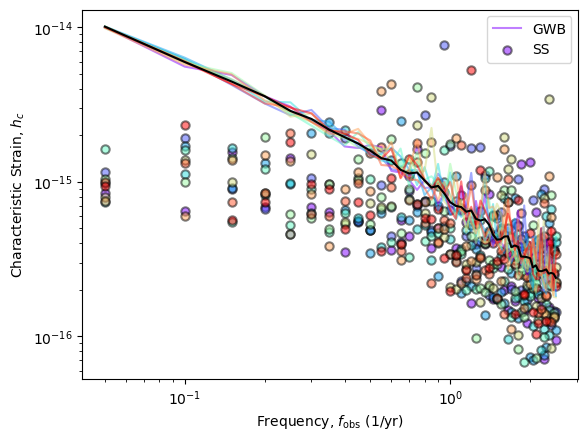

In [79]:
nreals = np.min([10, len(hc_bg[0])])
colors = cm.rainbow(np.linspace(0,1,nreals))
plt.xlabel('Frequency, $f_\mathrm{obs}$ (1/yr)')
plt.ylabel('Characteristic Strain, $h_c$')
for rr in range(nreals):
    if(rr==0):
        label_bg = 'GWB'
    else:
        label_bg = None
    plt.loglog(fobs*YR, hc_bg[:,rr], alpha=0.5, label=label_bg, color=colors[rr])
    for ll in range(len(hc_ss[0,0])):
        if ll ==0:
            edgecolor='k'
            alpha_ss = 0.5
            if(rr==0):
                label_ss = 'SS'
            else:
                label_ss = None
        else:
            edgecolor=None
            alpha_ss = 0.3
            label_ss=None
        plt.scatter(fobs*YR, hc_ss[:,rr,ll], alpha=alpha_ss, label=label_ss,
                    color=colors[rr], edgecolors=edgecolor, linewidths=1.5)
plt.loglog(fobs*YR, np.median(hc_bg, axis=1), color='k')
plt.legend()


In [80]:
# edges, number, fobs, exname = ss.example5(print_test=False)
# hc_bg, hc_ss, ssidx, hsamp, bgpar, sspar = ss.ss_by_cdefs(edges, number, 30, params=True)
# # example 5
# dur = 10.0*YR
# cad = .2*YR

# 2 Pulsar Setup
## 2.1 Make pulsars with hasasia

In [81]:
num = 20
phis = np.random.uniform(0, 2*np.pi, size = num)
thetas = np.random.uniform(np.pi/2, np.pi/2, size = num)
# sim uses dur in yrs and cad in #/yr
# make list of hasasia.Pulsar objects
pulsars = hsim.sim_pta(timespan = dur/YR, cad = 1/(cad/YR), sigma = 1e-7,
                      phi = phis, theta = thetas)
print(pulsars[0].__dict__.keys())

dict_keys(['toas', 'toaerrs', 'phi', 'theta', 'pdist', 'N', 'designmatrix'])


In [82]:
print(thetas)
print(phis)

[1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633]
[5.58900987 4.32421907 2.91908634 5.69948297 1.23008981 0.50642487
 5.14109163 6.01105981 3.4104606  1.22829901 1.95594359 4.90027329
 2.66523932 0.26578365 1.01631158 4.81584593 0.65332373 1.17185245
 4.66335672 2.10549237]


Make spectra

In [83]:
spectra = []

for pul in pulsars:
    spec = hsen.Spectrum(pul, freqs=fobs) # spectrum object
    spec.NcalInv # calculate inverse noise weighted transmission function along the way
    spectra.append(spec)
    # add white noise and add red noise here? 
    # add_noise_power(noise)
    # add_red_noise_power(A=None, gamma=None, vals=False)
    # add_white_noise_power(sigma=None, dt = None, vals=False)

## 2.2 Overlap Reduction Function

Using Rosado eq.s:
$$ \Gamma_{ij} = \frac{3}{2} \gamma_{ij} \ln (\gamma_{ij}) - \frac{1}{4} \gamma_{ij} + \frac{1}{2} + \frac{1}{2}\delta_{ij} $$
$$ \gamma_{ij} = [1-\cos (\theta_{ij})]/2$$

In [84]:
def gammaij_from_thetaij(theta_ij):
    """ Calcualte gamma_ij for two pulsars of relative angle theta_ij.
    
    Parameters
    ----------
    theta_ij : scalar 
        Relative angular position between the ith and jth pulsars.

    Returns
    -------
    gamma_ij : scalar 
        [1 - cos(theta_ij)]/2

    """
    return (1-np.cos(theta_ij))/2


def dirac_delta(i,j):
    """ Calculate the dirac delta function of i,j.
    Parameters
    ----------
    i : int
    j : int

    Returns
    ------- 
    dirac_ij : int
        Dirac delta function of i and j

    """
    if(i==j): return 1
    else: return 0

def relative_angle(theta_i, phi_i, theta_j, phi_j):
    """ Calculate relative angle between two pulsars i and j.
    
    Parameters
    ----------
    theta_i : scalar 
        Polar angular position in the sky of the ith pulsar.
    phi_i : scalar
        Azimuthal angular position in the sky of the ith pulsar.
    theta_j : scalar 
        Polar angular position in the sky of the jth pulsar.
    phi_j : scalara
        Azimuthal angular position in the sky of the jth pulsar.

    Returns
    -------
    theta_ij : scalar 
        Relative angular position between the ith and jth pulsar.

    """
    
    theta_ij = np.arccos(np.cos(phi_i)*np.cos(phi_j) 
                      + np.sin(phi_i)*np.sin(phi_j)*np.cos(theta_i - theta_j))
    
    return theta_ij

def orf_ij(i, j, theta_ij):
    """ Calculate the overlap reduction function Gamma_i,j as a function of theta_i, theta_j, i, and j.
    
    Parameters
    ----------
    i : int
        index of the ith pulsar
    j : int
        index of the jth pulsar
    theta_ij : scalar
        relative angular position between the ith and jth pulsars

    Returns
    -------
    Gamma : scalar
        The overlap reduction function of the ith and jth pulsars.


    Follows Rosado et al. 2015 Eq. (24)
    """
    dirac_ij = dirac_delta(i, j)
    gamma_ij = gammaij_from_thetaij(theta_ij)
    
    Gamma = (3/2 * gamma_ij *np.log(gamma_ij)
            - 1/4 * gamma_ij
            + 1/2 + dirac_ij)
    if(np.isnan(Gamma) and i!=j):
        print('Gamma_%d,%d is nan, set to 0' % (i,j))
        return 0
    return Gamma


def orf_all(pulsars):
    """ Calculate the overlap reduction function matrix Gamma for a list of hasasia.Pulsar objects

    Paramters
    ---------
    pulsars : (P,) list of hasasia.Pulsar objects.

    Returns
    -------
    Gamma : (P,P) NDarray
        Overlap reduction function matrix for all pulsars i,j with j>i
        Only for j>1, 0 for j<=i

    """

    Gamma = np.zeros((len(pulsars), len(pulsars)))
    for ii in range(len(pulsars)):
        for jj in range(len(pulsars)):
            if (jj>ii): # 0 otherwise, allows sum over all
                # calculate angle between two vectors.
                theta_ij =  relative_angle(pulsars[ii].theta, pulsars[ii].phi,
                                           pulsars[jj].theta, pulsars[jj].phi)
                print('theta_ij', theta_ij)
                # find ORF
                Gamma[ii,jj] = orf_ij(ii, jj, theta_ij)
    
    return Gamma


In [85]:
Gamma = orf_all(pulsars)
print(Gamma)

theta_ij 1.264790798038133
theta_ij 2.669923521253663
theta_ij 0.11047310858158733
theta_ij 1.9242652511732137
theta_ij 1.2006003069094082
theta_ij 0.4479182365873502
theta_ij 0.42204994787377964
theta_ij 2.17854926774458
theta_ij 1.9224744536907565
theta_ij 2.6501190328899455
theta_ij 0.6887365771026194
theta_ij 2.923770546605354
theta_ij 0.959959088029844
theta_ij 1.7104870241362982
theta_ij 0.7731639311060761
theta_ij 1.3474991765595568
theta_ij 1.8660278943694149
theta_ij 0.9256531419433686
theta_ij 2.799667810110531
theta_ij 1.4051327232155302
theta_ij 1.375263906619721
theta_ij 3.094129257968239
theta_ij 2.465391104947541
theta_ij 0.8168725614507828
theta_ij 1.6868407459119128
theta_ij 0.9137584697064473
theta_ij 3.095920055450697
theta_ij 2.3682754762515086
theta_ij 0.5760542209355134
theta_ij 1.6589797485672206
theta_ij 2.224749886067977
theta_ij 2.975277822174431
theta_ij 0.4916268669320569
theta_ij 2.6122899745976897
theta_ij 3.1308186924075603
theta_ij 0.3391376560947644
the

Using hasasia.GWBSensitivityCurve

In [86]:
scGWB = hsen.GWBSensitivityCurve(spectra) # orf='hd'
print(scGWB.__dict__.keys())
print(scGWB.chiIJ) 

dict_keys(['_H_0', 'Npsrs', 'phis', 'thetas', 'Tspan', 'freqs', 'SnI', 'ThetaIJ', 'chiIJ', 'pairs', 'chiRSS', 'T_IJ'])
[-1.38452469e-01  1.84034193e-01  4.72751356e-01 -6.79714113e-02
 -1.26513741e-01  2.65017428e-01  2.83276304e-01  1.91651729e-02
 -6.85220062e-02  1.78704170e-01  1.00213583e-01  2.35336616e-01
 -4.75835984e-02 -1.23266720e-01  4.84915425e-02 -1.48222556e-01
 -8.52185893e-02 -3.20655737e-02  2.14453870e-01 -1.51388847e-01
 -1.50114523e-01  2.49296378e-01  1.21903456e-01  2.35801594e-02
 -1.27843164e-01 -2.64501885e-02  2.49348447e-01  8.81891476e-02
  1.75163508e-01 -1.32774072e-01  3.60556873e-02  2.41411744e-01
  2.34126402e-01  1.68068548e-01  2.49963727e-01  3.40862482e-01
  3.38495853e-02  2.10460956e-01 -1.27440595e-01  1.03834827e-01
  3.50503530e-02  2.49231047e-01  2.34304671e-01 -1.27103924e-01
 -4.89719761e-02 -4.98775033e-02  3.96640839e-01  1.79572319e-01
 -7.44971127e-02 -7.62908735e-02  5.10765753e-02 -1.15474937e-01
 -1.16132987e-01  2.54007991e-02 -9.

## 2.3 Noise spectral density $P_i$ 
$$ P_i = 2 \Delta t \sigma_i^2 $$

In [87]:
def _white_noise(delta_t, sigma_i):
    """ Calculate the white noise for a given pulsar 2 /Delta t sigma_i^2
    
    Parameters
    ----------
    delta_t : scalar
        Detection cadence, in seconds.
    sigma_i : scalar
        Error/stdev/variance? for the ith pulsar, in seconds.

    Returns
    -------
    P_i : scalar
        Noise spectral density for the ith pulsar, for bg detection.
        For single source detections, the noise spectral density S_i must also 
        include red noise from all but the loudest single sources, S_h,rest. 
        Rosado et al. 2015 Eq. (23)

    """
    P_i = 2 * delta_t * sigma_i**2
    return P_i

In [88]:
sigmas = np.zeros(num)
for ii in range(num):
    sigmas[ii] = np.mean(pulsars[ii].toaerrs)
noise = _white_noise(cad, sigmas) 
print('P_i =', noise, 's^3 =', noise/YR**3,' yrs^3')

P_i = [1.262304e-07 1.262304e-07 1.262304e-07 1.262304e-07 1.262304e-07
 1.262304e-07 1.262304e-07 1.262304e-07 1.262304e-07 1.262304e-07
 1.262304e-07 1.262304e-07 1.262304e-07 1.262304e-07 1.262304e-07
 1.262304e-07 1.262304e-07 1.262304e-07 1.262304e-07 1.262304e-07] s^3 = [4.01653964e-30 4.01653964e-30 4.01653964e-30 4.01653964e-30
 4.01653964e-30 4.01653964e-30 4.01653964e-30 4.01653964e-30
 4.01653964e-30 4.01653964e-30 4.01653964e-30 4.01653964e-30
 4.01653964e-30 4.01653964e-30 4.01653964e-30 4.01653964e-30
 4.01653964e-30 4.01653964e-30 4.01653964e-30 4.01653964e-30]  yrs^3


# 3 Background Signal
## 3.1 Power Spectral Density
$S_h$, the one-sided power spectral density of the GW signal in the timing residuals
$$ S_h = \frac{h_c^2}{12 \pi ^2 f_k^3}$$

In [89]:
def power_spectral_density(hc_bg, freqs):
    """ Calculate the spectral density S_h(f_k) ~ S_h0(f_k) at the kth frequency

    Parameters
    ----------
    hc_bg : (F,) 1D array of scalars
        Characteristic strain of the background at each frequency. 
    freqs : (F,) 1Darray of scalars
        Frequency bin centers corresponding to each strain

    Returns
    -------
    S_h : (F,) 1Darray of scalars
        Actual (S_h) or ~construction (S_h0) value of the background spectral density. 
        In units of [freqs]^-3
    """

    S_h = hc_bg**2 / (12 * np.pi**2 * freqs**3)
    return S_h

In [90]:
Sh_bg = power_spectral_density(hc_bg[:,0], fobs) # spectral density of bg, using 0th realization
Sh0_bg = Sh_bg # approximation used in Rosado et al. 2015
print(Sh_bg)
print(scGWB.S_eff)

[2.14775281e-04 8.20132397e-06 1.89762670e-06 4.24921735e-07
 1.59784772e-07 5.96139750e-08 2.82234389e-08 1.18802851e-08
 7.96331717e-09 6.33008382e-09 4.46521662e-09 1.69862856e-09
 1.27191012e-09 8.13134873e-10 4.93896748e-10 5.42845693e-10
 3.88377265e-10 1.92601848e-10 2.17279102e-10 1.11306755e-10
 1.19144054e-10 1.74762760e-10 8.19951077e-11 4.68028009e-11
 7.66783537e-11 3.39875884e-11 7.28671094e-11 2.91669602e-11
 1.36807306e-11 1.40241443e-11 1.17676096e-11 9.20865734e-12
 8.81550001e-12 5.00475109e-12 5.46317678e-12 1.92002561e-11
 7.15118821e-12 3.07220081e-12 2.24378865e-12 2.30337396e-12
 4.43411375e-12 4.15333832e-12 2.98599703e-12 1.72549482e-12
 9.17475883e-13 3.86260729e-12 2.37564463e-12 1.68607495e-12
 1.50646294e-12 6.62520809e-13]
[5.85514752e-23 6.36297950e-23 1.33291306e-22 2.32338528e-22
 3.60064532e-22 5.16349099e-22 7.01185070e-22 9.14613498e-22
 1.15671805e-21 1.42764104e-21 1.72762199e-21 2.05707712e-21
 2.41676971e-21 2.80820632e-21 3.23467180e-21 3.70440

## 3.2 mu_1
$$\mu_1 = 1\sum_f \sum_{ij} \frac{\Gamma_{ij}^2 S_h S_{h0}}{[P_i + S_{h0}] [P_j + S_{h0}] + \Gamma_{ij}^2 S_{h0}^2} $$


In [91]:
def mean1_Bstatistic_loops(noise, Gamma, Sh_bg, Sh0_bg):
    """ Calculate mu_1 for the background, by summing over all pulsars and frequencies.
    Assuming the B statistic, which maximizes S/N_B = mu_1/sigma_1
    
    Parameters
    ----------
    noise : (P,) 1darray of scalars
        Noise spectral density of each pulsar.
    Gamma : (P,P) 2Darray of scalars
        Overlap reduction function for j>i, 0 otherwise.
    Sh_bg : (F,) 1Darray of scalars
        Spectral density in the background.
    Sh0_bg : (F,) 1Darray of scalars
        Value of spectral density used to construct the statistic.

    Returns
    -------
    mu_1B : 
        Expected value for the B statistic

    Follows Eq. (A16) from Rosado et al. 2015.
    """
    mu_1B = 0
    for ii in range(len(noise)):
        P_i = noise[ii]
        for jj in range(len(noise)): 
            if(jj>ii):
                P_j = noise[jj]
                Gamma_ij = Gamma[ii,jj]
                for kk in range(len(Sh_bg)):
                    Sh = Sh_bg[kk]
                    Sh0 = Sh0_bg[kk]
                    mu_1B += ((Gamma_ij**2 * Sh * Sh0)
                            /((P_i+Sh0) * (P_j+Sh0) 
                                + Gamma_ij**2 * Sh0**2))
    mu_1B *= 2
    return mu_1B

def mean1_Bstatistic_ndars(noise, Gamma, Sh_bg, Sh0_bg):
    """ Calculate mu_1 for the background, by summing over all pulsars and frequencies.
    Assuming the B statistic, which maximizes S/N_B = mu_1/sigma_1
    
    Parameters
    ----------
    noise : (P,) 1darray of scalars
        Noise spectral density of each pulsar.
    Gamma : (P,P) 2Darray of scalars
        Overlap reduction function for jj>ii, 0 otherwise.
    Sh_bg : (F,) 1Darray of scalars
        Spectral density in the background.
    Sh0_bg : (F,) 1Darray of scalars
        Value of spectral density used to construct the statistic.

    Returns
    -------
    mu_1B : 
        Expected value for the B statistic

    Follows Eq. (A16) from Rosado et al. 2015.
    """
    
    # to get sum term in shape (P,P,F) for ii,jj,kk we want:
    # Gamma in shape (P,P,1)
    # Sh0 and Sh in shape (1,1,F)
    # P_i in shape (P,1,1)
    # P_j in shape (1,P,1)

    numer = (Gamma[:,:,np.newaxis] **2 
            * Sh_bg[np.newaxis, np.newaxis, :]
            * Sh0_bg[np.newaxis, np.newaxis, :])
    denom = ((noise[:, np.newaxis, np.newaxis] + Sh0_bg[np.newaxis,np.newaxis,:])
               * (noise[np.newaxis, :, np.newaxis] + Sh0_bg[np.newaxis,np.newaxis,:])
               + Gamma[:,:,np.newaxis]**2 * Sh0_bg[np.newaxis, np.newaxis, :]**2)
    
    # should not need this part if Gamma takes all jj<=ii parts to zero
    sum = np.sum(numer/denom)
    mu_1B = 2*sum
    return mu_1B


In [92]:
mu_1B_loops = mean1_Bstatistic_loops(noise, Gamma, Sh_bg, Sh0_bg)
mu_1B = mean1_Bstatistic_ndars(noise, Gamma, Sh_bg, Sh0_bg)
print(mu_1B_loops, mu_1B)

50.220015241735176 50.22001524173522


## 3.3 sigma_0
$$ \sigma_0^2 = 2\sum_f \sum_{ij} \frac{\Gamma_{ij}^2 S_{h0}^2 P_i P_j  }{\big[ [P_i + S_{h0}] [P_j +S_{h0}] + \Gamma_{ij}^2 S_{h0}^2  \big]^2  } $$



In [93]:
def sigma0_Bstatistic_loops(noise, Gamma, Sh_bg, Sh0_bg):
    """ Calculate sigma_1 for the background, by summing over all pulsars and frequencies.
    Assuming the B statistic, which maximizes S/N_B = mu_1/sigma_1
    
    Parameters
    ----------
    noise : (P,) 1darray of scalars
        Noise spectral density of each pulsar.
    Gamma : (P,P) 2Darray of scalars
        Overlap reduction function for j>i, 0 otherwise.
    Sh_bg : (F,) 1Darray of scalars
        Spectral density in the background.
    Sh0_bg : (F,) 1Darray of scalars
        Value of spectral density used to construct the statistic.

    Returns
    -------
    sigma_0B : Scalar
        
    
    Follows Eq. (A17) from Rosado et al. 2015.
    """

    sigma_0B = 0 # sigma_1 squared
    for ii in range(len(noise)):
        P_i = noise[ii]
        for jj in range(len(noise)): 
            if(jj>ii):
                P_j = noise[jj]
                Gamma_ij = Gamma[ii,jj]
                for kk in range(len(Sh_bg)):
                    Sh0 = Sh0_bg[kk]
                    numer = Gamma_ij**2 * Sh0**2 * P_i * P_j
                    denom = ((P_i + Sh0) * (P_j + Sh0) 
                             + Gamma_ij**2 * Sh0**2)**2
                    sigma_0B += (numer/denom)
    
    sigma_0B = np.sqrt(2*sigma_0B)
    return sigma_0B


def sigma0_Bstatistic_ndars(noise, Gamma, Sh_bg, Sh0_bg):
    """ Calculate sigma_1 for the background, by summing over all pulsars and frequencies.
    Assuming the B statistic, which maximizes S/N_B = mu_1/sigma_1
    
    Parameters
    ----------
    noise : (P,) 1darray of scalars
        Noise spectral density of each pulsar.
    Gamma : (P,P) 2Darray of scalars
        Overlap reduction function for j>i, 0 otherwise.
    Sh_bg : (F,) 1Darray of scalars
        Spectral density in the background.
    Sh0_bg : (F,) 1Darray of scalars
        Value of spectral density used to construct the statistic.

    Returns
    -------
    sigma_0B : Scalar
        

    Follows Eq. (A17) from Rosado et al. 2015.
    """

    # to get sum term in shape (P,P,F) for ii,jj,kk we want:
    # Gamma in shape (P,P,1)
    # Sh0 and Sh in shape (1,1,F)
    # P_i in shape (P,1,1)
    # P_j in shape (1,P,1)

    numer = (Gamma[:,:,np.newaxis]**2 * Sh0_bg[np.newaxis,np.newaxis,:]**2 
             * noise[:,np.newaxis,np.newaxis] * noise[np.newaxis,:,np.newaxis])
    denom = ((noise[:,np.newaxis,np.newaxis] + Sh0_bg[np.newaxis, np.newaxis,:])
              * (noise[np.newaxis,:,np.newaxis] + Sh0_bg[np.newaxis,np.newaxis,:])
             + Gamma[:,:,np.newaxis]**2 * Sh0_bg[np.newaxis,np.newaxis,:]**2)**2
    
    sum = np.sum(numer/denom)
    sigma_0B = np.sqrt(2*sum)
    return sigma_0B



In [94]:
sigma_0B_loops = sigma0_Bstatistic_loops(noise, Gamma, Sh_bg, Sh0_bg)
sigma_0B = sigma0_Bstatistic_ndars(noise, Gamma, Sh_bg, Sh0_bg)
print(sigma_0B_loops, sigma_0B)

1.5363937732002377 1.5363937732002337


## 3.4 sigma_1
$$ \sigma_1^2 = 2 \sum_f \sum_{ij} \frac{\Gamma_{ij}^2 S_{h0}^2 \big[ [P_i + S_h] [P_j + S_h] + \Gamma_{ij}^2 S_h^2   \big]  }{\big[[P_i + S_{h0}][P_j + S_{h0}] + \Gamma_{ij}^2 S_{h0}^2  \big]^2  } $$

In [95]:
def sigma1_Bstatistic_loops(noise, Gamma, Sh_bg, Sh0_bg):
    """ Calculate sigma_1 for the background, by summing over all pulsars and frequencies.
    Assuming the B statistic, which maximizes S/N_B = mu_1/sigma_1
    
    Parameters
    ----------
    noise : (P,) 1darray of scalars
        Noise spectral density of each pulsar.
    Gamma : (P,P) 2Darray of scalars
        Overlap reduction function for j>i, 0 otherwise.
    Sh_bg : (F,) 1Darray of scalars
        Spectral density in the background.
    Sh0_bg : (F,) 1Darray of scalars
        Value of spectral density used to construct the statistic.

    Returns
    -------
    sigma_1B : Scalar
        

    Follows Eq. (A18) from Rosado et al. 2015.
    """

    sigma_1B = 0 # sigma_1 squared
    for ii in range(len(noise)):
        P_i = noise[ii]
        for jj in range(len(noise)): 
            if(jj>ii):
                P_j = noise[jj]
                Gamma_ij = Gamma[ii,jj]
                for kk in range(len(Sh_bg)):
                    Sh = Sh_bg[kk]
                    Sh0 = Sh0_bg[kk]
                    numer = (Gamma_ij**2 * Sh0**2 * 
                             ((P_i + Sh) * (P_j + Sh) 
                              + Gamma_ij**2 * Sh**2))
                    denom = ((P_i + Sh0) * (P_j + Sh0) 
                             + Gamma_ij**2 * Sh0**2)**2
                    sigma_1B += (numer/denom)
    
    sigma_1B = np.sqrt(2*sigma_1B)
    return sigma_1B


def sigma1_Bstatistic_ndars(noise, Gamma, Sh_bg, Sh0_bg):
    """ Calculate sigma_1 for the background, by summing over all pulsars and frequencies.
    Assuming the B statistic, which maximizes S/N_B = mu_1/sigma_1
    
    Parameters
    ----------
    noise : (P,) 1darray of scalars
        Noise spectral density of each pulsar.
    Gamma : (P,P) 2Darray of scalars
        Overlap reduction function for j>i, 0 otherwise.
    Sh_bg : (F,) 1Darray of scalars
        Spectral density in the background.
    Sh0_bg : (F,) 1Darray of scalars
        Value of spectral density used to construct the statistic.

    Returns
    -------
    sigma_1B : Scalar
        

    Follows Eq. (A18) from Rosado et al. 2015.
    """

    # to get sum term in shape (P,P,F) for ii,jj,kk we want:
    # Gamma in shape (P,P,1)
    # Sh0 and Sh in shape (1,1,F)
    # P_i in shape (P,1,1)
    # P_j in shape (1,P,1)

    numer = (Gamma[:,:,np.newaxis]**2 * Sh0_bg[np.newaxis,np.newaxis,:]**2 
             * ((noise[:,np.newaxis,np.newaxis] + Sh_bg[np.newaxis,np.newaxis,:])
                * (noise[np.newaxis,:,np.newaxis] + Sh_bg[np.newaxis,np.newaxis,:])
                + Gamma[:,:,np.newaxis]**2 * Sh_bg[np.newaxis,np.newaxis,:]**2))
             
    denom = ((noise[:,np.newaxis,np.newaxis] + Sh0_bg[np.newaxis, np.newaxis,:])
              * (noise[np.newaxis,:,np.newaxis] + Sh0_bg[np.newaxis,np.newaxis,:])
             + Gamma[:,:,np.newaxis]**2 * Sh0_bg[np.newaxis,np.newaxis,:]**2)**2
    
    sum = np.sum(numer/denom)
    sigma_1B = np.sqrt(2*sum)
    return sigma_1B



In [96]:
sigma_1B_loops = sigma1_Bstatistic_loops(noise, Gamma, Sh_bg, Sh0_bg)
sigma_1B = sigma1_Bstatistic_ndars(noise, Gamma, Sh_bg, Sh0_bg)
print(sigma_1B_loops, sigma_1B)

7.086608162000717 7.0866081620007195


## 3.5 SNR Check
$$S/N_B \equiv \frac{\mu_1}{ \sigma_1} = \Bigg[ 2 \sum_f \sum_{ij} \frac{\Gamma_{ij}^2 S_h^2}{P_iP_j + S_h[P_i + P_j] + S_h^2[1+\Gamma_{ij}^2]}   \Bigg]^{1/2} \quad\quad\quad(\mathrm{A}19)$$

In [97]:
def SNR_bg_B(noise, Gamma, Sh_bg):
    """ Calculate S/N_B for the background, using P_i, Gamma, S_h and S_h0
    
    Parameters
    ----------
    noise : (P,) 1darray of scalars
        Noise spectral density of each pulsar.
    Gamma : (P,P) 2Darray of scalars
        Overlap reduction function for j>i, 0 otherwise.
    Sh_bg : (F,) 1Darray of scalars
        Spectral density in the background.
    Sh0_bg : (F,) 1Darray of scalars
        Value of spectral density used to construct the statistic.

    Returns
    -------
    SNR_B : Scalar
        Signal to noise ratio assuming the B statistic
        

    Follows Eq. (A19) from Rosado et al. 2015.
    """


    # to get sum term in shape (P,P,F) for ii,jj,kk we want:
    # Gamma in shape (P,P,1)
    # Sh0 and Sh in shape (1,1,F)
    # P_i in shape (P,1,1)
    # P_j in shape (1,P,1)

    numer = Gamma[:,:,np.newaxis]**2 * Sh_bg[np.newaxis,np.newaxis,:]**2
    denom = (noise[:,np.newaxis,np.newaxis] * noise[np.newaxis,:,np.newaxis]
             + Sh_bg[np.newaxis,np.newaxis,:] * (noise[:,np.newaxis,np.newaxis]+noise[np.newaxis,:,np.newaxis])
             + Sh_bg[np.newaxis,np.newaxis,:]**2 * (1 + Gamma[:,:,np.newaxis]**2))

    sum = np.sum(numer/denom)
    SNR_B = np.sqrt(2*sum)
    return SNR_B

    

In [98]:
SNR_B = SNR_bg_B(noise, Gamma, Sh_bg)
print(SNR_B, mu_1B/sigma_1B)

7.0866081620007195 7.0866081620007195


compare to hasasia, where they get SNR as a function of $$S_h = \frac{3H_0^2}{2\pi^2} \frac{\Omega_\mathrm{gw}(f)}{f^3}$$ in units of strain^2/Hz, where $\Omega_{gw}=\frac{2\pi^2}{3\;H_0^2}f^3\;S_I$ 

In [99]:
print(scGWB.Omega_gw.shape)
print(scGWB._H_0.to('Hz'))

(50,)
2.3333610883999426e-18 Hz


In [100]:
def _Sh_hasasia_generic_bg(scGWB):
    """ Calculate the signal strain power spectral density, 
        `Sh` for hasasia's SNR calculation
        
    Parameters
    ----------
    scGWB : hasasia.sensitivity.GWBSensitivityCurve object
        GWB sensitivity curve object.
        
    Returns
    -------
    Sh_h : (F,) 1Darray
        Sh as used in hasasia's SNR calculation, for each frequency.
    
    """
    freqs = scGWB.freqs
    H0 = scGWB._H_0.to('Hz').value
    Omega_gw = scGWB.Omega_gw
    Sh_h = 3*H0**2 / (2*np.pi**2) * Omega_gw / freqs**3
    return Sh_h

def SNR_hasasia_generic_bg(scGWB):
    """ Calculate the GWB signal to noise ratio with hasasia.
    
    Parameters
    ----------
    scGWB : hasasia.sensitivity.GWBSensitivityCurve object
        GWB sensitivity curve object.
        
    Returns
    -------
    SNR_h : scalar
        Signal to noise ratio from hasasia.
    """
    Sh_h = _Sh_hasasia_generic_bg(scGWB)
    SNR_h = scGWB.SNR(Sh_h)
    return SNR_h
    


In [101]:
SNR_hg = SNR_hasasia_generic_bg(scGWB)

print(SNR_hg, SNR_B, mu_1B/sigma_1B) # close enough?

9.899494936611665 7.0866081620007195 7.0866081620007195


We could also use the real characeristic strains with equation (56)
$$h_c(f) \equiv \sqrt{f S_h(f)}$$
$$S_h{f} = h_c(f)^2/f$$

In [102]:
def _Sh_hasasia_modeled_bg(freqs, hc_bg):
    """ Calculate Sh for hsen.GWBSensitivityCurve.SNR(Sh) from a 
    modeled GWB characteristic strain.
    
    Parameters
    ----------
    freqs : (F,) 1Darray
        Frequencies of char strain.
    hc_bg : (F,R) NDarray
        GWB characteristic strain for each frequency and realization.
    
    Returns
    -------
    Sh_h : (F,R) NDarray
        Sh as used in hasasia's SNR calculation, for each frequency.
    """

    Sh_h = hc_bg**2 / freqs[:,np.newaxis]
    return Sh_h    

def SNR_hasasia_modeled_bg(scGWB, hc_bg):
    """ Calculate the GWB signal to noise ratio with hasasia.
    
    Parameters
    ----------
    scGWB : hasasia.sensitivity.GWBSensitivityCurve object
        GWB sensitivity curve object.
    hc_bg : (F,R) NDarray
        Realistic characteristic strain of the background.
        
    Returns
    -------
    SNR_h : (R) 1Darray)
        Signal to noise ratio from hasasia, for each realization.
    """
    Sh_h = _Sh_hasasia_modeled_bg(scGWB.freqs, hc_bg)
    SNR_h = np.zeros(len(hc_bg[0]))
    for rr in range(len(hc_bg[0])):
        SNR_h[rr] = scGWB.SNR(Sh_h[:,rr])
    return SNR_h

In [103]:
SNR_hr = SNR_hasasia_modeled_bg(scGWB, hc_bg)
print(SNR_hr)

[1113.30457276 1115.51912525 1138.77430169 1133.41140906 1084.49796851
 1135.24076733 1122.91495259 1080.46592329 1120.72111251 1104.99531321
 1186.31279785 1114.08891566 1139.42124364 1128.63730603 1126.57326301
 1134.51164419 1124.02762377 1127.08026685 1151.28631093 1152.27304349
 1144.3922197  1129.59799216 1095.28777704 1107.50985689 1106.621627
 1169.64340837 1126.07709772 1114.15693751 1150.74453767 1156.37640315]


compare Sh generic and Sh realistic, these look reasonably close

In [104]:
Sh_hg = _Sh_hasasia_generic_bg(scGWB)
Sh_hr = _Sh_hasasia_modeled_bg(scGWB.freqs, hc_bg)
print(Sh_hg)
print(np.mean(Sh_hr, axis=1))

[5.85514752e-23 6.36297950e-23 1.33291306e-22 2.32338528e-22
 3.60064532e-22 5.16349099e-22 7.01185070e-22 9.14613498e-22
 1.15671805e-21 1.42764104e-21 1.72762199e-21 2.05707712e-21
 2.41676971e-21 2.80820632e-21 3.23467180e-21 3.70440423e-21
 4.24296043e-21 4.96558264e-21 7.25852957e-21 3.44842208e+08
 8.87360312e-21 7.41770674e-21 7.76408567e-21 8.33011092e-21
 8.97767346e-21 9.67457533e-21 1.04098987e-20 1.11790618e-20
 1.19798521e-20 1.28110880e-20 1.36720896e-20 1.45624418e-20
 1.54818791e-20 1.64302254e-20 1.74073606e-20 1.84132003e-20
 1.94476849e-20 2.05107713e-20 2.16024287e-20 4.58452844e-20
 2.38713754e-20 2.50486398e-20 2.62544227e-20 2.74887225e-20
 2.87515408e-20 3.00428827e-20 3.13627560e-20 3.27111721e-20
 3.40881460e-20 3.54936963e-20]
[6.42935252e-20 1.13538124e-20 4.31416088e-21 2.00542676e-21
 1.06415587e-21 6.98008421e-22 4.56198795e-22 3.07141148e-22
 2.32866534e-22 1.78732366e-22 1.25753024e-22 1.09979043e-22
 7.63896388e-23 6.78678999e-23 5.80714616e-23 4.38770

most look reasonably close, but no idea why the generic gives a really high Sh at just one frequency.

## 3.6 Detection Probability
$$ \gamma_{bg} = \frac{1}{2} \mathrm{erfc} \big[ \frac{\sqrt{2} \sigma_0 \mathrm{erfc}^{-1}(2\alpha_0) - \mu_1}{\sqrt{2} \sigma_1}\big]

In [105]:
ALPHA0 = 0.001 # false alarm probability (FAP)

def bg_detection_probability(sigma_0, sigma_1, mu_1, alpha_0):
    """ Calculate the background detection probability, gamma_bg.

    Parameters
    ----------
    sigma_0 : scalar
        Standard deviation of stochastic noise processes.
    sigma_1 : scalar
        Standard deviation of GWB PDF.
    mu_1 : scalar
        Mean of GWB PDF.
    alpha_0 : scalar
        False alarm probability max.

    Returns
    -------
    dp_bg : scalar
        Background detection probability.

        
    Follows Rosado et al. 2015 Eq. (15)
    """
    temp = ((np.sqrt(2) * sigma_0 * sp.special.erfcinv(2*alpha_0) - mu_1)
            /(np.sqrt(2) * sigma_1))
    dp_bg = .5 * sp.special.erfc(temp)
    return dp_bg

In [106]:
dp_bg = bg_detection_probability(sigma_0B, sigma_1B, mu_1B, ALPHA0)
print(dp_bg)

0.9999999999303418


In [107]:
def detect_bg(THETAS, PHIS, SIGMAS, fobs, cad, hc_bg, return_all = False):
    """ Calculate the background detection probability, and all intermediary steps.

    Parameters
    ----------
    THETAS : (P,) 1Darray of scalars
        Latitudinal angular position of each pulsar in radians.
    PHIS: (P,) 1Darray of scalars
        Longitudinal angular position of each pulsar in radians.
    SIGMAS : (P,) 1Darray of scalars
        Sigma_i of each pulsar in seconds.
    fobs : (F,) 1Darray of scalars
        Frequency bin centers in hertz.
    cad : scalar
        Cadence of observations in seconds.
    hc_bg : (F,)
        Characteristic strain of the background at each frequency.
    return_all : Bool
        Whether to return all parameters or just dp_bg

    Returns
    -------
    dp_bg : scalar
        Background detection probability
    Gamma : (P, P) 2D Array
        Overlap reduction function for j>i, 0 otherwise.
        Only returned if return_all = True.
    Sh_bg : (F,) 1Darray
        Spectral density
        Only returned if return_all = True.
    noise : (P,) 1Darray
        Spectral noise density of each pulsar.
        Only returned if return_all = True.
    mu_1B : scalar
        Expected value for the B statistic.
        Only returned if return_all = True.
    sigma_0B : scalar
    sigma_1B : scalar

    """
    # Overlap Reduction Function
    num = len(THETAS) # number of pulsars, P
    Gamma = np.zeros((num, num)) # (P,P) 2Darray of scalars, Overlap reduction function between all puolsar
    for ii in range(num):
        for jj in range(num):
            theta_ij =  relative_angle(THETAS[ii], PHIS[ii],
                                        THETAS[jj], PHIS[jj])
            # find ORF
            Gamma[ii,jj] = orf_ij(ii, jj, theta_ij)

    # Spectral Density
    Sh_bg = power_spectral_density(hc_bg[:], fobs) # spectral density of bg, using 0th realization
    Sh0_bg = Sh_bg # approximation used in Rosado et al. 2015

    # Noise 
    noise = _white_noise(cad, SIGMAS) 

    mu_1B = mean1_Bstatistic_ndars(noise, Gamma, Sh_bg, Sh0_bg)

    sigma_0B = sigma0_Bstatistic_ndars(noise, Gamma, Sh_bg, Sh0_bg)

    sigma_1B = sigma1_Bstatistic_ndars(noise, Gamma, Sh_bg, Sh0_bg)

    dp_bg = bg_detection_probability(sigma_0B, sigma_1B, mu_1B, ALPHA0)

    if(return_all):
        return dp_bg, Gamma, Sh_bg, noise, mu_1B, sigma_0B, sigma_1B
    else:
        return dp_bg

# Full Walkthrough

In [108]:
# # example 5
# edges, number, fobs, exname = ss.example5(print_test=False)
# hc_bg, hc_ss, ssidx, hsamp, bgpar, sspar = ss.ss_by_cdefs(edges, number, 30, params=True)
# dur = 10.0*YR
# cad = .2*YR

Print Info

In [109]:
# num_pulsars = 40
# THETAS = np.random.uniform(0.001, 2*np.pi, num_pulsars) # (P,) 1Darray of scalars, angular sky position of each pulsar
# PHIS = np.random.uniform(0.001, np.pi, num_pulsars)
# SIGMAS = np.random.uniform(1e-6, 2e-6, num_pulsars) # (P,) 1Darray of scalars, sigma_i of each pulsar
# ALPHA0 = 0.001
# dp_bg, Gamma, Sh_bg, noise, mu_1B, sigma_0B, sigma_1B = \
#     detect_bg(THETAS, PHIS, SIGMAS, fobs, cad, hc_bg[:,1], return_all=True)
# print('Number of pulsars:',num_pulsars)
# print('\nOVERLAP')
# print('thetas (pi):\t%s' % str(holo.utils.stats(THETAS/np.pi)))
# print('Gamma:\t%s' % str(holo.utils.stats(Gamma)))
# # print('Gamma:\t', Gamma)

# print('\nNOISE')
# print('cadence (s): \t%.2e' % cad)
# print('sigmas (s): %s', str(holo.utils.stats(SIGMAS)))
# print('P_i (s^3):\t%s' % str(holo.utils.stats(noise)))

# print('\nSIGNAL')
# print('fobs (nHz): \t%s' % str(holo.utils.stats(fobs*10**9)))
# print('hc_bg:   \t%s' % str(holo.utils.stats(hc_bg[:,0])))
# print('S_h (s^3):\t%s' % str(holo.utils.stats(Sh_bg)))

# print('\nB STATISTICS')
# print('sigma_0: \t%.2e' % sigma_0B)
# print('sigma_1: \t%.2e' % sigma_1B)
# print('mu_1:    \t%.2e' % mu_1B)

# print('\nDETECTION PROB')
# print('DP_bg:   \t%.2e' % dp_bg)
# print('SNR_B:   \t%.2f' % (mu_1B/sigma_1B))

Compare to hasasia

In [110]:
# scGWB = hsen.GWBSensitivityCurve(spectra)

In [111]:
# # print(Sh_bg)
# print('pulsars:', pulsars[0].__dict__.keys())
# print('spectra:', spectra[0].__dict__.keys())
# print('scGWB:', scGWB.__dict__.keys())
# print(scGWB.S_eff)

## detect_bg_pta(pulsars)
can I get cad from pulsar objects?

In [112]:
# NOTE: Could modify this to take hc_bg[F,R], and return dp[R]

def detect_bg_pta(pulsars, spectra, cad, hc_bg, alpha_0=0.001, ret_all = False):
    """ Calculate the background detection probability, and all the intermediary steps
    from a list of hasasia.Pulsar objects.
    
    Parameters
    ----------
    pulsars : (P,) list of hasasia.Pulsar objects
        A set of pulsars generated by hasasia.sim.sim_pta()
    spectra : (P,) list of hasasia.Spectrum objects
        The spectrum for each pulsar.
    cad : scalar
        Cadence of observations in seconds.
    hc_bg : (F,)
        Characteristic strain of the background at each frequency.
    alpha_0 : scalar
        Falsa alarm probability
    return_all : Bool
        Whether or not to return intermediate variables.

    Returns
    -------
    dp_bg : scalar
        Background detection probability
    Gamma : (P, P) 2D Array
        Overlap reduction function for j>i, 0 otherwise.
        Only returned if return_all = True.
    Sh_bg : (F,) 1Darray
        Spectral density
        Only returned if return_all = True.
    noise : (P,) 1Darray
        Spectral noise density of each pulsar.
        Only returned if return_all = True.
    mu_1B : scalar
        Expected value for the B statistic.
        Only returned if return_all = True.
    sigma_0B : scalar
    sigma_1B : scalar
    """

    # check inputs
    assert len(pulsars) == len(spectra), f"'pulsars ({len(pulsars)}) does not match 'spectra' ({len(spectra)}) !"
    
    # get pulsar properties
    thetas = np.zeros(len(pulsars))
    phis = np.zeros(len(pulsars))
    sigmas = np.zeros(len(pulsars))
    for ii in range(len(pulsars)):
        thetas[ii] = pulsars[ii].theta
        phis[ii] = pulsars[ii].phi
        sigmas[ii] = pulsars[ii].toaerrs

    fobs = spectra[0].freqs

    Gamma = _orf_pta(pulsars)

    Sh_bg = _power_spectral_density(hc_bg[:], fobs)

    white_noise = _white_noise(cad, sigmas)

    mu_1B = _mean1_Bstatistic(noise, Gamma, Sh_bg, Sh0_bg)

    sigma_0B = _sigma0_Bstatistic(noise, Gamma, Sh_bg, Sh0_bg)

    sigma_1B = _sigma1_Bstatistic(noise, Gamma, Sh_bg, Sh0_bg)

    dp_bg = _bg_detection_probability(sigma_0B, sigma_1B, mu_1B, alpha_0)

    if(ret_all):
        return dp_bg, Gamma, Sh_bg, noise, mu_1B, sigma_0B, sigma_1B
    else:
        return dp_bg
    



In [113]:
print(spectra[0].toaerrs)

[1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07
 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07
 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07
 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07
 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07
 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07
 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07
 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07
 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07
 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07 1.e-07]


# 4 Single Sources Setup

## 4.1 Place binaries at random positions

(50, 30, 1)


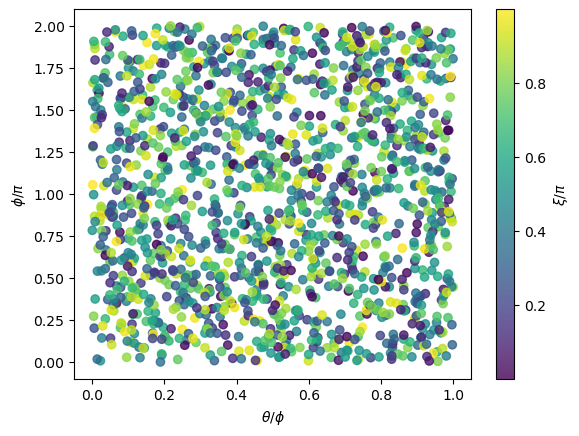

In [114]:
# shape (F,R,L)
ss_thetas = np.random.uniform(0, np.pi, size = hc_ss.size).reshape(hc_ss.shape)
ss_phis = np.random.uniform(0, 2*np.pi, size = hc_ss.size).reshape(hc_ss.shape)
ss_xis = np.random.uniform(0, np.pi, size = hc_ss.size).reshape(hc_ss.shape)
ss_Phi0s = np.random.uniform(0, 2*np.pi, size = hc_ss.size).reshape(hc_ss.shape)
print(ss_thetas.shape)
plt.scatter(ss_thetas/np.pi, ss_phis/np.pi, c=ss_xis/np.pi, cmap='viridis', alpha=0.8)
plt.xlabel(r'$\theta/\phi$')
plt.ylabel('$\phi/\pi$')
plt.colorbar(label=r'$\xi/\pi$ ')

## 4.2 Unitary vectors

$$\hat{m} = +[\sin (\phi)\cos(\xi) - \sin (\xi) cos(\phi) cos(\theta)] \hat{x} 

- [\cos (\phi) \cos(\xi) + \sin(\xi) \sin(\phi) \cos(\theta)] \hat{y} 

+ [\sin)(\xi)\sin(\phi)]\hat{z} \quad\quad\quad(40)$$

$$ \hat{n} = +[-\sin(\phi) \sin(\xi) - \cos(\xi) \cos(\phi) \cos(\theta)] \hat{x} 
+[\cos(\phi) \sin(\xi) - \cos(\xi) \sin(\phi) \cos(\theta)] \hat{y} 
+[\cos(\xi) \sin(\theta)]\hat{z} \quad\quad\quad(41)$$

$$\hat{\Omega} = -\sin(\theta) \cos(\phi) \hat{x}  - \sin(\theta) \sin(\phi) \hat{y} - \cos(\theta) \hat{z} \quad\quad\quad(42)$$

These are functions of $\theta$ and $\phi$, the angular position of the binary, and $\xi$, the inclination of the binary. 

In [115]:
def _m_unitary_vector(theta, phi, xi):
    """ Calculate the unitary vector m-hat for the antenna pattern functions.
    
    Parameters
    ----------
    theta : (F,R,L) NDarray
        Spherical coordinate position of each single source.
    phi : (F,R,L) NDarray
        Spherical coordinate position of each single source.
    xi : (F,R,L) NDarray
        Inclination of binary? But thought that's what iota was?    
    
    Returns
    -------
    m_hat : (3,F,R,L) NDarray 
        Unitary vector m-hat with x, y, and z components at 
        index 0, 1, and 2, respectively.
        
    """
    mhat_x = (np.sin(phi) * np.cos(xi) 
              - np.sin(xi) * np.cos(phi) * np.cos(theta))
    mhat_y = -(np.cos(phi) * np.cos(xi)
               + np.sin(xi) * np.sin(phi) * np.cos(theta))
    mhat_z = (np.sin(xi) * np.sin(theta))

    m_hat = np.array([mhat_x, mhat_y, mhat_z])
    return m_hat

def _n_unitary_vector(theta, phi, xi):
    """ Calculate the unitary vector n-hat for the antenna pattern functions.
    
    Paramters
    ---------
    theta : (F,R,L) NDarray
        Spherical coordinate position of each single source.
    phi : (F,R,L) NDarray
        Spherical coordinate position of each single source.
    xi : (F,R,L) 1Darray
        Inclination of binary? But thought that's what iota was?    
    
    Returns
    -------
    n_hat : (3,F,R,L) NDarray
        Unitary vector n-hat.
        
    """

    nhat_x = (- np.sin(phi) * np.sin(xi) 
              - np.cos(xi) * np.cos(phi) * np.cos(theta))
    nhat_y = (np.cos(phi) * np.sin(xi) 
              - np.cos(xi) * np.sin(phi) * np.cos(theta))
    nhat_z = np.cos(xi) * np.sin(theta)

    n_hat = np.array([nhat_x, nhat_y, nhat_z])
    return n_hat

def _Omega_unitary_vector(theta, phi):
    """ Calculate the unitary vector n-hat for the antenna pattern functions.
    
    Paramters
    ---------
    theta : (F,R,L) NDarray
        Spherical coordinate position of each single source.
    phi : (F,R,L) NDarray
        Spherical coordinate position of each single source.
    
    Returns
    -------
    Omega_hat : (3,F,R,L) NDarray
        Unitary vector Omega-hat.
    """

    Omegahat_x = - np.sin(theta) * np.cos(phi)
    Omegahat_y = - np.sin(theta) * np.sin(phi)
    Omegahat_z = - np.cos(theta)

    Omega_hat = np.array([Omegahat_x, Omegahat_y, Omegahat_z])
    return Omega_hat



In [116]:
m_hat = _m_unitary_vector(ss_thetas, ss_phis, ss_xis)
n_hat = _n_unitary_vector(ss_thetas, ss_phis, ss_xis)
Omega_hat = _Omega_unitary_vector(ss_thetas, ss_phis)
print(m_hat.shape, holo.utils.stats(np.sum(m_hat**2, axis=0)), '\n', 
      n_hat.shape, holo.utils.stats(np.sum(n_hat**2, axis=0)), '\n',  
      Omega_hat.shape, holo.utils.stats(np.sum(Omega_hat**2, axis=0))) # should all be 1
print(m_hat.shape, m_hat[:,0,0,0])
print(n_hat.shape, n_hat[:,0,0,0])
print(Omega_hat.shape, Omega_hat[:,0,0,0])

(3, 50, 30, 1) 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00 
 (3, 50, 30, 1) 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00 
 (3, 50, 30, 1) 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00
(3, 50, 30, 1) [0.88013052 0.09472869 0.46518463]
(3, 50, 30, 1) [-0.19641204  0.96475053  0.17515342]
(3, 50, 30, 1) [-0.43219506 -0.24552573  0.86771225]


Compare to hasasia, using just the 0th realization
* Omega_hat ($\hat{\Omega}$ in Rosado+2015) -> hsky.K ($\hat{k}$ in Hazboun+2019)
* m_hat ($\hat{m}$ in Rosado+2015) -> hsky L ($\hat{l}$ in Hazboun+2019)
* n_hat ($\hat{n}$ in Rosado+2015) -> hsky M ($\hat{m}$ in Hazboun+2019), -M if we use $\pi - \theta$ for colatitude

In [117]:
# compare using just the 0th realization, just the loudest source
# thetas_gw = np.pi - ss_thetas[:,0]  # pi - latitude gives colatitude, which reverses the sign of hsky.M
thetas_gw = ss_thetas[:,0,0] 
phis_gw = ss_phis[:,0,0]
print(len(spectra), thetas_gw.shape, phis_gw.shape)
skymap = hsky.SkySensitivity(spectra, thetas_gw, phis_gw)
print('K of 0th freq source:', skymap.K[:,0],
      '\nL of 0th freq source:', skymap.L[:,0], 
      '\nM of 0th freq source:', skymap.M[:,0])
print('\nOmega-hat', Omega_hat[:,0,0,0],
      '\nm-hat:', m_hat[:,0,0,0],
      '\nn-hat', n_hat[:,0,0,0])

20 (50,) (50,)
K of 0th freq source: [-0.43219506 -0.24552573  0.86771225] 
L of 0th freq source: [ 0.49394912 -0.86949081  0.        ] 
M of 0th freq source: [0.75446782 0.4286057  0.49706686]

Omega-hat [-0.43219506 -0.24552573  0.86771225] 
m-hat: [0.88013052 0.09472869 0.46518463] 
n-hat [-0.19641204  0.96475053  0.17515342]


## 4.3 Pulsar unitary vector
$$ \hat{p}_i = \sin(\theta_i) \cos(\phi_i) \hat{x} + \sin(\theta_i) \sin(\phi_i) \hat{y} + \cos(\theta_i) \hat{z} \quad\quad\quad(43)$$
where $\theta_i$ and $\phi_i$ give the angular position of the ith pulsar.

In [118]:
def _pi_unitary_vector(phi_i, theta_i):
    """ Calculate the unitary vector p_i-hat for the ith pulsar.
    
    Parameters
    ----------
    phi : (P,) 1Darray
        Spherical coordinate position of each pulsar.
    theta : (P,) 1Darray
        Spherical coordinate position of each pulsar.
    Returns
    -------
    pi_hat : (3,P) vector
        pulsar unitary vector
    
    """

    pihat_x = np.sin(theta_i) * np.cos(phi_i)
    pihat_y = np.sin(theta_i) * np.sin(phi_i)
    pihat_z = np.cos(theta_i)

    pi_hat = np.array([pihat_x, pihat_y, pihat_z])
    return pi_hat

In [119]:
pi_hat = _pi_unitary_vector(phis, thetas)
print(holo.utils.stats(np.sum(pi_hat**2, axis=1))) # should all be 1
print(pi_hat.shape, pi_hat[:,0])

7.50e-32, 7.50e-32, 7.50e-32, 8.63e+00, 1.14e+01, 1.14e+01, 1.14e+01
(3, 20) [ 7.68581476e-01 -6.39751917e-01  6.12323400e-17]


## 4.4 Antenna Pattern Functions
$$ F_i^+ = \frac{1}{2}  \frac{[\hat{m}\cdot \hat{p}_i]^2 - \hat{n} \cdot \hat{p}_i]^2}{1  + \hat{\Omega} \cdot \hat{p}_i} $$
 
 $$ F_i^\times = \frac{\hat{m} \cdot \hat{p}_i] [\hat{n} \cdot \hat{p}_i]}{1 + \hat{\Omega} \cdot \hat{p}_i}

In [120]:
def dotprod(vec1, vec2):
    """ Calculate the dot product for NDarrays of 3D vectors, with
     vector elements specified by the first index. 
     
     Parameters
     ----------
     vec1 : (3,N1,N2,N3,...N) NDarray
     vec2 : (3,N1,N2,N3,...N) NDarray

     Returns
     -------
     dotted : (N1,N2,N3,...N) NDarray
        The dot product of the vectors specified by the first dimension,
        for every N1, N2, N3,...N.

    Example: find the dot product of 3D vectors for every P,F,R, using NDarrays
    of shape (3,P,F,R)
     """
    
    dotted = vec1[0,...]*vec2[0,...] + vec1[1,...]*vec2[1,...] + vec1[2,...]*vec2[2,...]
    return dotted


def _antenna_pattern_functions(m_hat, n_hat, Omega_hat, pi_hat):
    """ + antenna pattern function for the ith pulsar.
    
    Parameters
    ----------
    m_hat : (3,F,R,L) NDarray
        Single source m_hat unitary vector for each frequency and realization.
    n_hat : (3,F,R,L) NDarray
        Single source mnhat unitary vector for each frequency and realization.
    Omega_hat : (3,F,R,L) NDarray
        Single source Omega_hat unitary vector for each frequency and realization.
    pi_hat : (3,P) NDarray
        Pulsar term unitary vector for the ith pulsar.
        
    Returns
    -------
    F_iplus : (P,F,R,L) NDarray
        Plus antenna pattern function for each pulsar and binary of each realization.
    F_icross : (P,F,R,L) NDarray
        Cross antenna pattern function for each pulsar and binary of each realization. 
    
    """
    mh = m_hat[:,np.newaxis,:,:]
    nh = n_hat[:,np.newaxis,:,:]
    Oh = Omega_hat[:,np.newaxis,:,:]
    ph = pi_hat[:,:,np.newaxis,np.newaxis,np.newaxis]
    denom = 1 + dotprod(Oh, ph)
    F_iplus = ((dotprod(mh, ph)**2 - dotprod(nh, ph)**2) 
               / denom / 2)
    F_icross = dotprod(mh, ph) * dotprod(nh, ph) / denom
    
    return F_iplus, F_icross
    

In [121]:
F_iplus, F_icross = _antenna_pattern_functions(m_hat, n_hat, Omega_hat, pi_hat)
print(F_iplus.shape, holo.utils.stats(F_iplus))
print(F_icross.shape, holo.utils.stats(F_icross))

(20, 50, 30, 1) -9.99e-01, -6.59e-01, -4.26e-01, -2.70e-03, 4.21e-01, 6.62e-01, 9.96e-01
(20, 50, 30, 1) -9.96e-01, -6.53e-01, -4.19e-01, 4.56e-03, 4.27e-01, 6.55e-01, 9.98e-01


Compare to hasasia, using just the 0th realization
* $F_{i,\mathrm{plus}}$ ~> skymap.Fcross
* $F_{i,\mathrm{cross}}$ ~> skymap.Fplus

These don't correspond exactly, but are closeish idk

In [122]:
print(skymap.Fplus.shape)
print(skymap.Fcross.shape)
# 0th frequency, 0th realization, 0th loudest, all pulsars
print('skymap.Flpus\n', np.sort(skymap.Fplus[:,0]))
print('skymap.Fcross\n', np.sort(skymap.Fcross[:,0]))
# print('skymap.Flong', skymap.Flong)
# print('skymap.Fbreathe', skymap.Fbreathe)


print('F_icross\n', np.sort(F_icross[:,0,0,0]))
print('F_iplus\n', np.sort(F_iplus[:,0,0,0]))


(20, 50)
(20, 50)
skymap.Flpus
 [-0.51873999 -0.49526554 -0.4742843  -0.47261361 -0.41294697 -0.35213322
 -0.29902388 -0.19600443 -0.18759329 -0.09959614 -0.01556011  0.00170056
  0.00419249  0.03011616  0.08423759  0.21847349  0.31087041  0.62192336
  0.70962843  0.74831361]
skymap.Fcross
 [-0.69195598 -0.68819418 -0.68791387 -0.64737416 -0.31003144 -0.30308585
 -0.26599462 -0.23079047 -0.22847543 -0.12063665 -0.07272515  0.01553681
  0.01759757  0.139209    0.31223094  0.31593756  0.34680012  0.40240488
  0.45257976  0.66776293]
F_icross
 [-0.61254551 -0.57348936 -0.56762226 -0.35841932 -0.33832835 -0.25704493
 -0.25145395 -0.24774185 -0.06051065  0.00271922  0.03945452  0.10376611
  0.10771265  0.24768204  0.48031894  0.51820249  0.52005673  0.57567769
  0.64150897  0.69164161]
F_iplus
 [-0.46948407 -0.45243183 -0.45074361 -0.41537609 -0.4032127  -0.40020123
 -0.39305758 -0.36202663 -0.35180936 -0.19330187 -0.17726146 -0.12777274
 -0.01190118  0.06492298  0.19667902  0.2560335   0.3

## 4.5 Amplitude, A

$$ A = 2 \frac{G^{5/3} \mathcal{M}^{5/3} [\pi f [1+z]]^{2/3}}{c^4 r} \quad (5)$$
$ h = A\sqrt{\frac{1}{2}[a^2+b^2]} \quad (4)$ ?? a and b are defined by i, is that related to hc_ss then??
$$ h_s = \frac{8}{10^{1/2}} \frac{(G\mathcal{M})^{5/3}}{c^4 d_L} (2\pi f_r)^{2/3}  = \frac{2^{2/3}\times8}{2\times10^{1/2}} \times \big[ 2 \frac{(G\mathcal{M})^{5/3}}{c^4 d_L} (\pi f_r)^{2/3} \big] =  \frac{4(2)^{1/6}}{\sqrt{5}} A $$
$$ h_{c,ss}^2 = h_s^2 / dlnf = h_s^2 * f / df $$
$$ h_{c,ss} = h_s \sqrt{f/df} \frac{4(2)^{1/6}}{\sqrt{5}} A * f / df$$
$$ A = \frac{\sqrt{5}}{4 (2)^{1/6}} \sqrt{\frac{df}{f}} h_{c,ss} $$

In [123]:
def _amplitude(hc_ss, f, df):
    """ Calculate the amplitude from the single source to use in DP calculations
    
    Parameters
    ----------
    hc_ss : (F,R,L) NDarray
        Characteristic strain of each single source at each realization.
    f : (F,) 1Darray
        Frequency
    df : (F,) 1Darray
        Frequency bin widths.

    Returns
    -------
    Amp : (F,R,L)
        Dimensionless amplitude, A, of each single source at each frequency and realization.
    
    """

    Amp = hc_ss * np.sqrt(5) / 4 / 2**(1/6) *np.sqrt(df[:,np.newaxis,np.newaxis]/f[:,np.newaxis,np.newaxis])
    return Amp

In [124]:
df = np.diff(edges[-1])
amp = _amplitude(hc_ss, fobs, df)
print(amp.shape, holo.utils.stats(amp))

(50, 30, 1) 2.87e-18, 6.49e-18, 1.07e-17, 3.30e-17, 1.29e-16, 2.85e-16, 2.30e-15


## 4.6 ss_noise
Noise from all other sources in the same frequency bin except for the loudest
$$ S_{h,\mathrm{rest}} = \frac{h_{c,\mathrm{rest}}^2}{f} \frac{1}{12 \pi^2 f^2} \quad\quad\quad(45)$$
Included in total noise spectral density for the ith pulsar
$$S_i = 2\Delta t \sigma_i^2 + S_{h,\mathrm{rest}}\quad\quad\quad(44)$$

In [125]:
def _Sh_rest_noise(hc_ss, hc_bg, freqs):
    """ Calculate the noise spectral density contribution from all but the current single source.

    Parameters
    ----------
    hc_ss : (F,R,L) NDarray
        Characteristic strain from all loud single sources.
    hc_bg : (F,R) NDarray
        Characteristic strain from all but loudest source at each frequency.
    freqs : (F,) 1Darray
        Frequency bin centers.
        
    Returns
    -------
    ss_noise : (F,R,L) NDarray of scalars
        The noise in a single pulsar from other GW sources for detecting each single source.

    Follows Eq. (45) in Rosado et al. 2015.
    TODO: modify this to allow for multiple loud sources.
    """
    hc2_louds = np.sum(hc_ss**2, axis=2) # (F,R) 
    # subtract the single source from rest of loud sources and the background, for each single source
    hc2_rest = hc_bg[:,:,np.newaxis]**2 + hc2_louds[:,:,np.newaxis] - hc_ss**2 # (F,R,L)
    Sh_rest = hc2_rest / freqs[:,np.newaxis,np.newaxis]**3 /(12 * np.pi**2) # (F,R,L)
    return Sh_rest

# otherwise calculate from scratch
def _total_noise(delta_t, sigmas, hc_ss, hc_bg, freqs):
    """ Calculate the noise spectral density of each pulsar, s it pertains to single
    source detections, i.e., including the background as a noise source. 

    Parameters
    ----------
    delta_t : scalar
        Detection cadence, in seconds.
    sigmas : (P,) 1Darray
        Variance for the ith pulsar, in seconds
    hc_ss : (F,R,L) NDarray
        Characteristic strain from all loud single sources.
    hc_bg : (F,R) NDarray
        Characteristic strain from all but loudest source at each frequency.
    freqs : (F,) 1Darray
        Frequency bin centers.
        
    Returns
    -------
    noise : (P,F,R,L) NDarray of scalars
        The total noise in each pulsar for detecting each single source

    Follows Eq. (44) in Rosado et al. 2015.
    """

    noise = _white_noise(delta_t, sigmas) # (P,)
    Sh_rest = _Sh_rest_noise(hc_ss, hc_bg, freqs) # (F,R,L,)
    noise = noise[:,np.newaxis,np.newaxis,np.newaxis] + Sh_rest[np.newaxis,:,:,:] # (P,F,R,L)
    return noise

In [126]:
tot_noise = _total_noise(cad, sigmas, hc_ss, hc_bg, fobs)
print(tot_noise.shape, holo.utils.stats(tot_noise))

(20, 50, 30, 1) 1.26e-07, 1.26e-07, 1.26e-07, 1.26e-07, 1.40e-07, 1.69e-06, 2.27e-04


## 4.7 Polarization contributions
$$ a = 1 + \cos^2 \iota $$
$$ b = -2 \cos \iota $$

Where $\iota$ is the binary inclination angle.

In [127]:
def _a_b_polarization(iotas):
    """ Polarization contribution variables a and b.
    
    Parameters
    ----------
    iotas : scalar or NDarray
        Typically will be (F,R,L) NDarray

    Returns
    -------
    a_pol : scalar or NDarray
        Same shape as iota
    b_pol : scalar or NDarray
        Same shape as iota

    """
    a_pol = 1 + np.cos(iotas) **2
    b_pol = -2 * np.cos(iotas)
    return a_pol, b_pol

In [128]:
ss_iotas = ss_xis
a_pol, b_pol = _a_b_polarization(ss_iotas)

## 4.8 GW Phase
$\Phi_0$ is the initial phase and describes the signal detected on Earth. $\Phi(t) = 2\pi f t$, and 
$$\Phi_T = 2 \pi f T \quad\quad\quad (47)$$ 
where $T$ is the duration. 

In [129]:
def _gw_phase(dur, freqs, Phi_0):
    """ Calculate the detected gravitational wave phase at each frequency.

    Parameters
    ----------
    dur : scalar
        Duration (time elapsed from initial phase to detection)
    freqs : (F,) 1Darray
        Frequency of each single source.
    Phi_0 : (F,R,L) NDarray
        Initial GW phase of each binary.

    Returns
    -------
    Phi_T : (F,R,L) NDarray
        Detected GW phase of each single source.
    """

    Phi_T = 2 * np.pi * freqs[:,np.newaxis,np.newaxis] * dur + Phi_0
    return Phi_T

## 4.9 SNR 
### 4.9.1 SNR for a single pulsar
$$ \mathrm{S/N}_i^2 = \frac{A^2}{S_i 8 \pi^3 f^3} \bigg[a^2[F_i^+]^2 \Big[\Phi_T [1 + 2 \sin^2(\Phi_0)]
+ \cos(\Phi_T)[-\sin(\Phi_T) + 4 \sin(\Phi_0)] - 4\sin(\Phi_0)\Big] \\
+ b^2[F_i^\times]^2 \Big[\Phi_T[1+2\cos^2(\Phi_0)] + \sin(\Phi_T)[\cos(\Phi_T) - 4\cos(\Phi_0)]\Big] \\
- 2ab F_i^+ F_i^\times \Big[2\Phi_T \sin(\Phi_0) \cos(\Phi_0) 
+ \sin(\Phi_T)[\sin(\Phi_T) - 2\sin(\Phi_0) + 2\cos(\Phi_T) \cos(\Phi_0) - 2\cos(\Phi_0)]\Big]\bigg]\quad\quad\quad(46) $$

### 4.9.2 Total SNR (for each single source)
$$\mathrm{S/N_S} = \Big[ \sum_{i=1}^{M} \mathrm{S/N}_i^2\Big]^{1/2} \quad\quad\quad(35)$$

breaking up the SNR_i equation into pieces:
$$ \mathrm{Term 1} = a^2[F_i^+]^2 \Big[\Phi_T [1 + 2 \sin^2(\Phi_0)] + \cos(\Phi_T)[-\sin(\Phi_T) + 4 \sin(\Phi_0)] - 4\sin(\Phi_0)\Big] $$
$$ \mathrm{Term 2} =+ b^2[F_i^\times]^2 \Big[\Phi_T[1+2\cos^2(\Phi_0)] + \sin(\Phi_T)[\cos(\Phi_T) - 4\cos(\Phi_0)]\Big] $$
$$\mathrm{Term 3} = - 2ab F_i^+ F_i^\times \Big[2\Phi_T \sin(\Phi_0) \cos(\Phi_0) \\
+ \sin(\Phi_T)[\sin(\Phi_T) - 2\sin(\Phi_0) + 2\cos(\Phi_T) \cos(\Phi_0) - 2\cos(\Phi_0)]\Big] $$

$$\mathrm{Coef} =  \frac{A^2}{S_i 8 \pi^3 f^3}$$
$$S/N_i^2 = \mathrm{Coef} \bigg[\mathrm{Term1} + \mathrm{Term2} + \mathrm{Term3}\bigg]$$

In [130]:
def _SNR_ss(amp, F_iplus, F_icross, iotas, dur, Phi_0, S_i, freqs):
    """ Calculate the SNR for each pulsar wrt each single source detection.

    Paramters
    ---------
    amp : (F,R,L) NDarray 
        Dimensionless strain amplitude for loudest source at each frequency.
    F_iplus : (P,F,R,L) NDarray
        Antenna pattern function for each pulsar.
    F_icross : (P,F,R,L) NDarray
        Antenna pattern function for each pulsar.
    iotas : (F,R,L) NDarray
        Is this inclination? or what?
        Gives the wave polarizations a and b.
    dur : scalar
        Duration of observations.
    Phi_0 : (F,R,L) NDarray
        Initial GW Phase.
    S_i : (P,F,R,L) NDarray
        Total noise of each pulsar wrt detection of each single source, in s^3
    freqs : (F,) 1Darray 

    Returns
    -------
    SNR_ss : (F,R,L) NDarray
        SNR from the whole PTA for each single source.

    """
    
    amp = amp[np.newaxis,:,:,:]  # (F,R,L) to (P,F,R,L)
    # print('amp', amp.shape)

    a_pol, b_pol = _a_b_polarization(iotas)
    a_pol = a_pol[np.newaxis,:,:,:] # (F,R,L) to (P,F,R,L)
    b_pol = b_pol[np.newaxis,:,:,:] # (F,R,L) to (P,F,R,L)
    # print('a_pol', a_pol.shape)
    # print('b_pol', b_pol.shape)

    Phi_T = _gw_phase(dur, freqs, Phi_0) # (F,R,L)
    # print('Phi_T', Phi_T.shape)
    Phi_T = Phi_T[np.newaxis,:,:,:] # (F,) to (P,F,R,L)
    # print('Phi_T', Phi_T.shape)

    Phi_0 = Phi_0[np.newaxis,:,:,:] # (P,F,R,L)
    # print('Phi_0', Phi_0.shape)

    freqs = freqs[np.newaxis,:,np.newaxis,np.newaxis] # (F,) to (P,F,R,L)
    # print('freqs', freqs.shape)

    coef = amp**2 / (S_i * 8 * np.pi**3 * freqs**3) # [S_i] s^3 and [freqs^3] Hz^3 cancel
    
    term1 = a_pol**2 * F_iplus**2 * (Phi_T * (1 + 2 * np.sin(Phi_0)**2) 
                                     + np.cos(Phi_T)*(-np.sin(Phi_T) + 4 * np.sin(Phi_0)) 
                                     - 4*np.sin(Phi_0))
    
    term2 = b_pol**2 * F_icross**2 * (Phi_T*(1+2*np.cos(Phi_0)**2) 
                                      + np.sin(Phi_T)*(np.cos(Phi_T) - 4 * np.cos(Phi_0)))
    
    term3 = - (2*a_pol*b_pol*F_iplus*F_icross 
               * (2*Phi_T*np.sin(Phi_0)*np.cos(Phi_0)
                  + np.sin(Phi_T)*(np.sin(Phi_T) - 2*np.sin(Phi_0) 
                                   + 2*np.cos(Phi_T)*np.cos(Phi_0) 
                                   - 2*np.cos(Phi_0))))
    
    SNR2_pulsar_ss = coef*(term1 + term2 + term3) # (P,F,R,L)

    SNR_ss = np.sqrt(np.sum(SNR2_pulsar_ss, axis=0)) # (F,R,L), sum over the pulsars
    return SNR_ss

In [131]:
SNR_ss = _SNR_ss(amp=amp, F_iplus=F_iplus, F_icross=F_icross, iotas=ss_iotas,
                 dur = dur, Phi_0=ss_Phi0s, S_i=tot_noise, freqs=fobs)
print(SNR_ss.shape, holo.utils.stats(SNR_ss))

(50, 30, 1) 1.17e-03, 4.61e-03, 8.68e-03, 4.54e-02, 3.79e-01, 9.17e-01, 6.20e+00


Compare to hasasia DeterSensitivityCurve.
$$  \rho(\hat{n})=h_0\sqrt{\frac{T_{\rm obs}}{S_{\rm eff}(f_0 ,\hat{k})}} \quad\quad\quad(79) $$ 
from Hazboun et al. 2019.
This might be more comparable to my results if $S_\mathrm{eff}$ is replaced with the noise spectral density that I am using.

Here we use the 0th realization, 0th loudest source

In [132]:
scDeter = hsen.DeterSensitivityCurve(spectra)
rho_h_ss = scDeter.SNR(hc_ss[:,0,0]) 
print(rho_h_ss.shape), holo.utils.stats(rho_h_ss)
print('SNR_ss of 0th realization, 0th loudest source:\n', SNR_ss[:,0,0])
print('SNR using hasasia:', rho_h_ss)

(50,)
SNR_ss of 0th realization, 0th loudest source:
 [0.19032856 0.60967097 1.08334137 0.80376332 0.95081584 0.61399219
 0.63555083 0.15183321 0.12073307 0.15648271 0.54360605 0.07964289
 0.08932064 0.1374072  0.41466436 0.0671762  0.0808725  0.06145692
 0.04526187 0.1298708  0.03084108 0.05515733 0.09337661 0.00619979
 0.05041773 0.08011004 0.05845934 0.08861884 0.00696454 0.02131451
 0.01344539 0.0073064  0.01105777 0.01464528 0.01288044 0.04155833
 0.06877873 0.00536997 0.00759802 0.08404467 0.00784558 0.02241846
 0.00629053 0.00754105 0.00263114 0.00855394 0.00382476 0.01682027
 0.00819393 0.00319971]
SNR using hasasia: [6.84550566e+00 5.00224403e+00 8.28978865e+00 2.78747651e+00
 4.61354066e+00 1.87494003e+00 1.49398228e+00 7.19211435e-01
 1.00984134e+00 7.92551219e-01 4.35519267e+00 4.95784041e-01
 7.11390515e-01 5.20771985e-01 1.76601026e+00 7.61993921e-01
 3.52499107e-01 4.37811515e-01 6.19776481e-01 2.19965862e-15
 2.43493437e-01 5.92000672e-01 3.82217060e-01 1.11006401e-01
 

## 4.10 Threshold F-statistic $\cal{\bar{F}}_e$ 

Calculated from
$$ \alpha_0 = 1 - [1 - [1 + \cal{\bar{F}}_e]e^{-\cal{\bar{F}}_e}]^N \quad\quad\quad(31)$$
where $\alpha_0$ is the fixed value false alarm probability and $N$ is the number of single sources (in that realization).

$$ 0 = 1 - [1 - [1 + \cal{\bar{F}}_e]e^{-\cal{\bar{F}}_e}]^N - \alpha_0 $$
Note, this is the same across all realizations, since it just depends on the number of single sources.

In [133]:
# def _func_Fe_thresh(Fe_bar, Num, alpha_0):
#     # this is only needed for fsolve
#     rv =  1 - (1 - (1 + Fe_bar)*np.exp(-Fe_bar))**Num - alpha_0
#     return rv

# def _Fe_thresh_fsolve(Num, alpha_0=0.001):
#     """ Calculate the threshold F_e statistic using scipy.fsolve.
    
#     Parameters
#     ----------
#     Num : int
#         Number of single sources to detect.
#     alpha_0 : scalar
#         False alarm probability max.

#     Returns
#     -------
#     Fe_bar : scalar
#         Threshold Fe statistic

#     This function doesn't work.
#     """
    
#     Fe_bar = sp.optimize.fsolve(_func_Fe_thresh, 1, args=(Num, alpha_0))[0]
#     return Fe_bar

# import sympy

def _Fe_thresh(Num, alpha_0=0.001):
    """ Calculate the threshold F_e statistic using sympy.nsolve
    
    Parameters
    ----------
    Num : int
        Number of single sources to detect.
    alpha_0 : scalar
        False alarm probability max.

    Returns
    -------
    Fe_bar : scalar
        Threshold Fe statistic
    """
    Fe_bar = sympy.Symbol('Fe_bar')
    func = 1 - (1 - (1 + Fe_bar)*np.e**(-Fe_bar))**Num - alpha_0
    Fe_bar = sympy.nsolve(func, Fe_bar, 10)
    return(Fe_bar)

From Wolfram Alpha, Num=25 should give Fe_bar=12.7, Num=125 should give Fe_bar = 14.47 (and many other values particularly -1, complex numbers, and 0)

In [134]:
Num = hc_ss[:,0,:].size # does not depend on realizations
print(Num)
Fe_bar = _Fe_thresh(Num)
print(Fe_bar)

50
13.4929504352644


## 4.11 Detection Probability
### 4.11.1 DP of one single source
$$\gamma_i = \int_{\cal{\bar{F}}_e}^\infty p_1(\cal{F}_e, \rho) d \cal{F}_e \\
= \int_{\cal{\bar{F}}_e}^\infty \frac{[2\cal{F}_e]^{1/2}}{\rho} I_1(\rho\sqrt{2\cal{F}_e}) e^{-\cal{F}_e-\frac{1}{2} \rho^2} d\cal{F}_e$$
with $\rho=\mathrm{S/N_i}$ and $\cal{\bar{F}}_e$ calculated from $ \alpha_0 = 1 - [1 - [1 + \cal{\bar{F}}_e]e^{-\cal{\bar{F}}_e}]^N$ where $N$ is the number of single sources (in that realization)


I should check this with a test case on Mathematica. On Wolfram alpha I tried: 

integrate sqrt(2* F)/rho * (modified bessel function of the first kind(rho * sqrt(2*F))) * exp(-F - 1/2 rho^2) dF from 14.47 to infinity for rho=0.66085444,

or

integrate sqrt(2*F)/0.66085444 * (modified bessel first kind(0.66085444 * sqrt(2*F))) * exp(-F - 1/2 *0.66085444^2) dF from 14.47 to infinity 

but this timed out. Need to try mathematica instead.

In [135]:
def _integrand_gamma_ss_i(Fe, rho):

    I_1 = sp.special.i1(rho*np.sqrt(2*Fe))
    rv = (2*Fe)**(1/2) /rho * I_1 * np.exp(-Fe - rho**2 /2)
    return rv

def _gamma_ssi(Fe_bar, rho):
    """ Calculate the detection probability for each single source in each realization.
    
    Parameters
    ----------
    rho : (F,R,L) NDarray
        Given by the total PTA signal to noise ratio, S/N_S, for each single source
    Fe_bar : scalar
        The threshold F_e statistic

    Returns
    -------
    gamma_ssi : (F,R,L) NDarray
        The detection probability for each single source, i, at each frequency and realization.

    TODO: Find a way to do this without the embedded for-loops.
    """
    gamma_ssi = np.zeros((rho.shape))
    for ff in range(len(rho)):
        for rr in range(len(rho[0])):
            for ll in range(len(rho[0,0])):
                gamma_ssi[ff,rr,ll] = sp.integrate.quad(_integrand_gamma_ss_i, Fe_bar, np.inf, args=(rho[ff,rr,ll]))[0]
                if(np.isnan(gamma_ssi[ff,rr,ll])):
                    print(f'gamma_ssi[{ff},{rr},{ll}] is nan, setting to 0.')
                    gamma_ssi[ff,rr,ll] = 0
   

    return gamma_ssi


def _gamma_ssi(Fe_bar, rho):
    """ Calculate the detection probability for each single source in each realization.
    
    Parameters
    ----------
    rho : (F,R,L) NDarray
        Given by the total PTA signal to noise ratio, S/N_S, for each single source
    Fe_bar : scalar
        The threshold F_e statistic

    Returns
    -------
    gamma_ssi : (F,R,L) NDarray
        The detection probability for each single source, i, at each frequency and realization.

    TODO: Find a way to do this without the embedded for loops!
    """
    gamma_ssi = np.zeros((rho.shape))
    for ff in range(len(rho)):
        for rr in range(len(rho[0])):
            for ll in range(len(rho[0,0])):
                gamma_ssi[ff,rr,ll] = sp.integrate.quad(_integrand_gamma_ss_i, Fe_bar, np.inf, args=(rho[ff,rr,ll]))[0]
                if(np.isnan(gamma_ssi[ff,rr,ll])):
                    print(f'gamma_ssi[{ff},{rr},{ll}] is nan, setting to 0.')
                    gamma_ssi[ff,rr,ll] = 0
   

    return gamma_ssi



In [136]:
gamma_ssi = _gamma_ssi(Fe_bar, rho=SNR_ss)
print(gamma_ssi.shape, holo.utils.stats(gamma_ssi))
print(gamma_ssi.shape, gamma_ssi[:,0,0]) 

gamma_ssi[14,10,0] is nan, setting to 0.
(50, 30, 1) 0.00e+00, 2.00e-05, 2.00e-05, 2.01e-05, 3.01e-05, 1.20e-04, 1.46e-01
(50, 30, 1) [2.23592021e-05 5.19741905e-05 2.04884691e-04 8.90662958e-05
 1.37386819e-04 5.25686903e-05 5.56659185e-05 2.14879192e-05
 2.09375290e-05 2.15817926e-05 4.38828440e-05 2.04106190e-05
 2.05146666e-05 2.12159929e-05 3.25374091e-05 2.02945040e-05
 2.04231620e-05 2.02479371e-05 2.01387747e-05 2.10854194e-05
 2.00696283e-05 2.02014973e-05 2.05619151e-05 2.00122220e-05
 2.01698991e-05 2.04153612e-05 2.02252061e-05 2.05067100e-05
 2.00128546e-05 2.00383668e-05 2.00211685e-05 2.00131613e-05
 2.00174911e-05 2.00232873e-05 2.00202336e-05 2.01185020e-05
 2.03083061e-05 2.00116186e-05 2.00134344e-05 2.04564293e-05
 2.00136747e-05 2.00414032e-05 2.00122932e-05 2.00133802e-05
 2.00102415e-05 2.00144048e-05 2.00107257e-05 2.00275898e-05
 2.00140258e-05 2.00104498e-05]


Try using the hasasia SNR's instead
But is this the actual SNR, or just the SNR sensitivity?

In [137]:
# print(rho_h_ss.shape, rho_h_ss)
gamma_ssi_h = _gamma_ssi(Fe_bar=Fe_bar, rho=rho_h_ss[:,np.newaxis,np.newaxis])
print(gamma_ssi_h.shape, gamma_ssi_h.squeeze())


gamma_ssi[0,0,0] is nan, setting to 0.
gamma_ssi[2,0,0] is nan, setting to 0.
(50, 1, 1) [0.00000000e+00 5.41235744e-01 0.00000000e+00 2.18954391e-02
 3.92426076e-01 2.15291765e-03 7.10205003e-04 7.00060427e-05
 1.64040831e-04 8.62299196e-05 3.00663927e-01 3.90646200e-05
 6.84928508e-05 4.14828656e-05 1.57845731e-03 7.89999315e-05
 2.87031373e-05 3.42097163e-05 5.33780052e-05 2.00098064e-05
 2.39326614e-05 4.96306305e-05 3.04226678e-05 2.07925284e-05
 2.44461058e-05 3.19841491e-05 6.07765696e-05 3.80607408e-05
 2.06182943e-05 2.41154607e-05 2.14259715e-05 2.06802226e-05
 2.03461678e-05 2.06750377e-05 2.04033895e-05 2.38269526e-05
 4.83056494e-05 2.02617354e-05 2.01761602e-05 3.05628391e-05
 2.07226834e-05 2.41284497e-05 2.02959292e-05 2.02346202e-05
 2.00526794e-05 2.04556650e-05 2.01908233e-05 2.12889935e-05
 2.09728417e-05 2.00702847e-05]


Text(0, 0.5, 'SNR')

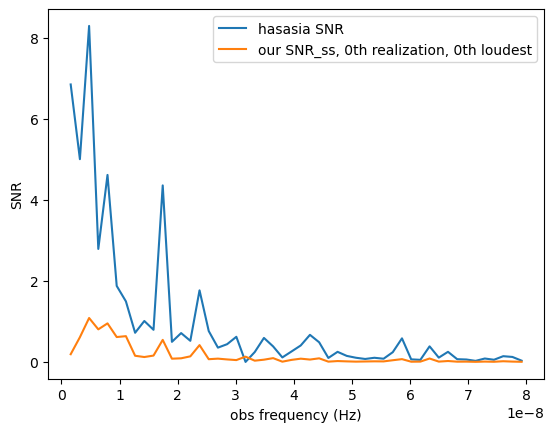

In [148]:
plt.plot(fobs, rho_h_ss, label='hasasia SNR') # looks like actual SNR, not sensitivity
plt.plot(fobs, SNR_ss[:,0,0], label='our SNR_ss, 0th realization, 0th loudest')
plt.legend()
plt.xlabel('obs frequency (Hz)')
plt.ylabel('SNR')

Why do I have one random nan value??

### 4.11.2 Detection Probability of any single source
$$\gamma_{ss} = 1 - \prod_{i}[1-\gamma_i]$$

In [139]:
def _ss_detection_probability(gamma_ss_i):
    """ Calculate the probability of detecting any single source, given individual single 
    source detection probabilities.
    
    
    Parameters
    ----------
    gamma_ss_i : (F,R,L) NDarray
        Detection probability of each single source, at each frequency and realization.

    Returns
    -------
    gamma_ss : (R) 1Darray
        Detection probability of any single source, for each realization
    """
    
    gamma_ss = 1 - np.product(1-gamma_ss_i, axis=(0,2))
    return gamma_ss

In [140]:
gamma_ss = _ss_detection_probability(gamma_ssi)
print(gamma_ss.shape, holo.utils.stats(gamma_ss))
print(gamma_ss.squeeze())

(30,) 1.22e-03, 1.31e-03, 1.56e-03, 2.22e-03, 1.30e-02, 8.08e-02, 1.47e-01
[0.00152094 0.00691365 0.01126459 0.00283776 0.00140654 0.00169486
 0.0021393  0.00698174 0.00456558 0.00305448 0.01580217 0.00230133
 0.00164158 0.00154961 0.08077854 0.14690185 0.00122373 0.0017845
 0.01366957 0.00221651 0.00262325 0.02967839 0.01071239 0.00184279
 0.00172688 0.00159991 0.00223119 0.00219532 0.00131173 0.00174392]


In [141]:
gamma_ss_h = _ss_detection_probability(gamma_ssi_h)
print(gamma_ss_h.shape, gamma_ss_h)

(1,) [0.81046332]


Several binaries have hasasia SNR's about an order of magnitude higher than the SNR's we calculated. That order of magnitude makes a big difference in the total detection probability!

In [142]:
def detect_ss(thetas, phis, sigmas, cad, dur, 
              fobs, dfobs, hc_ss, hc_bg, alpha_0=0.001, ret_all=False,
              theta_ss=None, phi_ss=None, iota_ss=None, xi_ss=None, Phi0_ss=None):
    """ Calculate the single source detection probability, and all intermediary steps.
    
    Parameters
    ----------
    thetas : (P,) 1Darray of scalars
        Polar (latitudinal) angular position of each pulsar in radians.
    phis : (P,) 1Darray of scalars
        Azimuthal (longitudinal) angular position of each pulsar in radians.
    sigmas : (P,) 1Darray of scalars
        Sigma_i of each pulsar in seconds.
    cad : scalar
        Cadence of observations in seconds.
    dur : scalar
        Duration of observations in seconds. 
    fobs : (F,) 1Darray of scalars
        Frequency bin centers in hertz.
    dfobs : (F-1,) 1Darray of scalars
        Frequency bin widths in hertz.
    hc_ss : (F,R,L) NDarray of scalars
        Characteristic strain of the L loudest single sources at 
        each frequency, for R realizations.
    hc_bg : (F,R)
        Characteristic strain of the background at each frequency, 
        for R realizations.
    alpha_0 : scalar
        False alarm probability
    ret_all : Bool
        Whether to return all parameters or just dp_bg
    theta_ss : (F,R,L) NDarray or None
        Polar (latitudinal) angular position in the sky of each single source.
        If None, random values between 0 and pi will be assigned.
    phi_ss : (F,R,L) NDarray or None
        Azimuthal (longitudinal) angular position in the sky of each single source.
        If None, random values between 0 and 2pi will be assigned.
    iota_ss : (F,R,L) NDarray or None
        Inclination of each single source with respect to the line of sight.
        If None, random values between 0 and pi will be assigned.
    xi_ss : (F,R,L) NDarray or None
        ???
        If None, assigned same random values as iota_ss, because I think these
        might both be referring to the same thing.
    Phi0_ss : (F,R,L) NDarray or None
        Initial GW phase.
        If None, random values between 0 and 2pi will be assigned.

    Returns
    -------
    gamma_ss : (R,) 1Darray
        Probability of detecting any single source, for each realization.

    """

    # Assign random single source sky positions, if not provided.
    if theta_ss is None:
        theta_ss = np.random.uniform(0, np.pi, size = hc_ss.size).reshape(hc_ss.shape)
    if phi_ss is None:
        phi_ss = np.random.uniform(0, 2*np.pi, size = hc_ss.size).reshape(hc_ss.shape)
    if iota_ss is None:
        iota_ss = np.random.uniform(0, np.pi, size = hc_ss.size).reshape(hc_ss.shape)
    if xi_ss is None:
        xi_ss = iota_ss # edit this when I figure out what xi is!
    if Phi0_ss is None:
        Phi0_ss = np.random.uniform(0,2*np.pi, size=hc_ss).reshape(hc_ss.shape)

    # unitary vectors
    m_hat = _m_unitary_vector(theta_ss, phi_ss, xi_ss) # (3,F,R,L)
    n_hat = _n_unitary_vector(theta_ss, phi_ss, xi_ss) # (3,F,R,L)
    Omega_hat = _Omega_unitary_vector(theta_ss, phi_ss) # (3,F,R,L)
    pi_hat = _pi_unitary_vector(phis, thetas) # (3,P)

    # antenna pattern functions
    F_iplus, F_icross = _antenna_pattern_functions(m_hat, n_hat, Omega_hat, 
                                                   pi_hat) # (P,F,R,L)
    
    # noise spectral density
    S_i = _total_noise(cad, sigmas, hc_ss, hc_bg, fobs)

    # amplitudw
    amp = _amplitude(hc_ss, fobs, dfobs) # (F,R,L)

    # SNR (includes a_pol, b_pol, and Phi_T calculations internally)
    SNR_ss = _SNR_ss(amp, F_iplus, F_icross, iota_ss, dur, Phi0_ss, S_i, fobs) # (F,R,L)
    
    Num = hc_ss[:,0,:].size
    Fe_bar = _Fe_thresh(Num) # scalar

    gamma_ssi = _gamma_ssi(Fe_bar, rho=SNR_ss) # (F,R,L)
    gamma_ss = _ss_detection_probability(gamma_ssi) # (R,)

    if ret_all:
        return F_iplus, F_icross, SNR_ss, gamma_ss
    else:
        return gamma_ss



In [143]:

def detect_ss_pta(pulsars, cad, dur, fobs,
              dfobs, hc_ss, hc_bg, alpha_0=0.001, ret_all=False):
    """ Calculate the single source detection probability, and all intermediary steps.
    
    Parameters
    ----------
    pulsars : (P,) list of hasasia.Pulsar objects
        A set of pulsars generated by hasasia.sim.sim_pta()
    cad : scalar
        Cadence of observations in seconds.
    dur : scalar
        Duration of observations in seconds. 
    fobs : (F,) 1Darray
        Frequency bin centers (in Hz).
    dfobs : (F-1,) 1Darray of scalars
        Frequency bin widths in hertz.
    hc_ss : (F,R,L) NDarray of scalars
        Characteristic strain of the L loudest single sources at 
        each frequency, for R realizations.
    hc_bg : (F,R)
        Characteristic strain of the background at each frequency, 
        for R realizations.
    alpha_0 : scalar
        False alarm probability
    ret_all : Bool
        Whether to return all parameters or just dp_bg
    theta_ss : (F,R,L) NDarray or None
        Polar (latitudinal) angular position in the sky of each single source.
        If None, random values between 0 and pi will be assigned.
    phi_ss : (F,R,L) NDarray or None
        Azimuthal (longitudinal) angular position in the sky of each single source.
        If None, random values between 0 and 2pi will be assigned.
    iota_ss : (F,R,L) NDarray or None
        Inclination of each single source with respect to the line of sight.
        If None, random values between 0 and pi will be assigned.
    xi_ss : (F,R,L) NDarray or None
        ???
        If None, assigned same random values as iota_ss, because I think these
        might both be referring to the same thing.
    Phi0_ss : (F,R,L) NDarray or None
        Initial GW phase.
        If None, random values between 0 and 2pi will be assigned.

    Returns
    -------
    gamma_ss : (R,) 1Darray
        Probability of detecting any single source, for each realization.

    """
    # Assign random single source sky positions, if not provided.
    if theta_ss is None:
        theta_ss = np.random.uniform(0, np.pi, size = hc_ss.size).reshape(hc_ss.shape)
    if phi_ss is None:
        phi_ss = np.random.uniform(0, 2*np.pi, size = hc_ss.size).reshape(hc_ss.shape)
    if iota_ss is None:
        iota_ss = np.random.uniform(0, np.pi, size = hc_ss.size).reshape(hc_ss.shape)
    if xi_ss is None:
        xi_ss = iota_ss # edit this when I figure out what xi is!
    if Phi0_ss is None:
        Phi0_ss = np.random.uniform(0,2*np.pi, size=hc_ss).reshape(hc_ss.shape)

    # unitary vectors
    m_hat = _m_unitary_vector(theta_ss, phi_ss, xi_ss) # (3,F,R,L)
    n_hat = _n_unitary_vector(theta_ss, phi_ss, xi_ss) # (3,F,R,L)
    Omega_hat = _Omega_unitary_vector(theta_ss, phi_ss) # (3,F,R,L)


     # get pulsar properties
    thetas = np.zeros(len(pulsars))
    phis = np.zeros(len(pulsars))
    sigmas = np.zeros(len(pulsars))
    for ii in range(len(pulsars)):
        thetas[ii] = pulsars[ii].theta
        phis[ii] = pulsars[ii].phi
        sigmas[ii] = np.mean(pulsars[ii].toaerrs)

    pi_hat = _pi_unitary_vector(phis, thetas) # (3,P)

    # antenna pattern functions
    F_iplus, F_icross = _antenna_pattern_functions(m_hat, n_hat, Omega_hat, 
                                                   pi_hat) # (P,F,R,L)
    
    # noise spectral density
    S_i = _total_noise(cad, sigmas, hc_ss, hc_bg, fobs)

    # amplitudw
    amp = _amplitude(hc_ss, fobs, dfobs) # (F,R,L)

    # SNR (includes a_pol, b_pol, and Phi_T calculations internally)
    SNR_ss = _SNR_ss(amp, F_iplus, F_icross, iota_ss, dur, Phi0_ss, S_i, fobs) # (F,R,L)
    
    Num = hc_ss[:,0,:].size
    Fe_bar = _Fe_thresh(Num) # scalar

    gamma_ssi = _gamma_ssi(Fe_bar, rho=SNR_ss) # (F,R,L)
    gamma_ss = _ss_detection_probability(gamma_ssi) # (R,)

    if ret_all:
        return F_iplus, F_icross, SNR_ss, gamma_ss
    else:
        return gamma_ss



In [144]:
def detect_ss_scDeter(pulsars, scDeter, hc_ss, ret_all=False,
              theta_ss=None, phi_ss=None, iota_ss=None, xi_ss=None, Phi0_ss=None):
    """ Calculate the single source detection probability, and all intermediary steps.
    
    Parameters
    ----------
    \
    sigmas : (P,) 1Darray of scalars
        Sigma_i of each pulsar in seconds.
    cad : scalar
        Cadence of observations in seconds.
    dur : scalar
        Duration of observations in seconds. 
    fobs : (F,) 1Darray of scalars
        Frequency bin centers in hertz.
    dfobs : (F-1,) 1Darray of scalars
        Frequency bin widths in hertz.
    hc_ss : (F,R,L) NDarray of scalars
        Characteristic strain of the L loudest single sources at 
        each frequency, for R realizations.
    hc_bg : (F,R)
        Characteristic strain of the background at each frequency, 
        for R realizations.
    alpha_0 : scalar
        False alarm probability
    ret_all : Bool
        Whether to return all parameters or just dp_bg
    theta_ss : (F,R,L) NDarray or None
        Polar (latitudinal) angular position in the sky of each single source.
        If None, random values between 0 and pi will be assigned.
    phi_ss : (F,R,L) NDarray or None
        Azimuthal (longitudinal) angular position in the sky of each single source.
        If None, random values between 0 and 2pi will be assigned.
    iota_ss : (F,R,L) NDarray or None
        Inclination of each single source with respect to the line of sight.
        If None, random values between 0 and pi will be assigned.
    xi_ss : (F,R,L) NDarray or None
        ???
        If None, assigned same random values as iota_ss, because I think these
        might both be referring to the same thing.
    Phi0_ss : (F,R,L) NDarray or None
        Initial GW phase.
        If None, random values between 0 and 2pi will be assigned.

    Returns
    -------
    gamma_ss : (R,) 1Darray
        Probability of detecting any single source, for each realization.

    """

    # get pulsar properties
    thetas = np.zeros(len(pulsars))
    phis = np.zeros(len(pulsars))
    sigmas = np.zeros(len(pulsars))
    for ii in range(len(pulsars)):
        thetas[ii] = pulsars[ii].theta
        phis[ii] = pulsars[ii].phi
        sigmas[ii] = np.mean(pulsars[ii].toaerrs)

    # Assign random single source sky positions, if not provided.
    if theta_ss is None:
        theta_ss = np.random.uniform(0, np.pi, size = hc_ss.size).reshape(hc_ss.shape)
    if phi_ss is None:
        phi_ss = np.random.uniform(0, 2*np.pi, size = hc_ss.size).reshape(hc_ss.shape)
    if iota_ss is None:
        iota_ss = np.random.uniform(0, np.pi, size = hc_ss.size).reshape(hc_ss.shape)
    if xi_ss is None:
        xi_ss = iota_ss # edit this when I figure out what xi is!
    if Phi0_ss is None:
        Phi0_ss = np.random.uniform(0,2*np.pi, size=hc_ss).reshape(hc_ss.shape)

    # unitary vectors
    m_hat = _m_unitary_vector(theta_ss, phi_ss, xi_ss) # (3,F,R,L)
    n_hat = _n_unitary_vector(theta_ss, phi_ss, xi_ss) # (3,F,R,L)
    Omega_hat = _Omega_unitary_vector(theta_ss, phi_ss) # (3,F,R,L)
    pi_hat = _pi_unitary_vector(phis, thetas) # (3,P)

    # antenna pattern functions
    F_iplus, F_icross = _antenna_pattern_functions(m_hat, n_hat, Omega_hat, 
                                                   pi_hat) # (P,F,R,L)

    # rho_ss (corresponds to SNR)
    rho_h_ss = np.zeros(hc_ss.shape) # (F,R,L)
    for rr in range(len(hc_ss[0])):
        for ll in range(len(hc_ss[0,0])):
            rho_h_ss[:,rr,ll] =   scDeter.SNR(hc_ss[:,rr,ll]) 
    
    Num = hc_ss[:,0,:].size
    Fe_bar = _Fe_thresh(Num) # scalar

    gamma_ssi = _gamma_ssi(Fe_bar, rho=rho_h_ss) # (F,R,L)
    gamma_ss = _ss_detection_probability(gamma_ssi) # (R,)

    if ret_all:
        return F_iplus, F_icross, SNR_ss, gamma_ss
    else:
        return gamma_ss



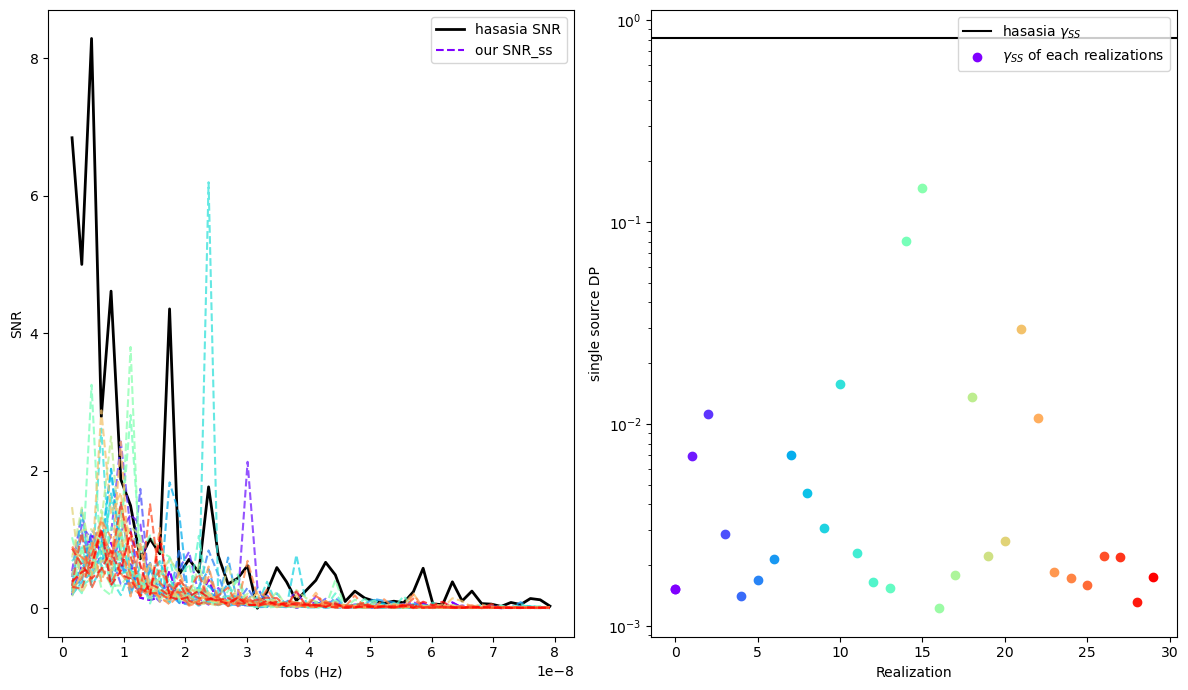

In [151]:
fig, axs = plt.subplots(1,2, figsize=(12,7))
colors = cm.rainbow(np.linspace(0,1,len(hc_ss[0])))
axs[0].plot(fobs, rho_h_ss, label='hasasia SNR', color='black', linewidth=2) # looks like actual SNR, not sensitivity
axs[0].plot(fobs, SNR_ss[:,0,0], color=colors[0], linestyle='--', label='our SNR_ss')
for rr in range(len(hc_ss[0])):
    axs[0].plot(fobs, SNR_ss[:,rr,0], linestyle='--', alpha=0.75, color = colors[rr])
axs[0].set_xlabel('fobs (Hz)')
axs[0].set_ylabel('SNR')
axs[0].legend()

axs[1].axhline(gamma_ss_h, color= 'k', label='hasasia $\gamma_{SS}$')
axs[1].scatter(0, gamma_ss[0], color = colors[0], label='$\gamma_{SS}$ of each realizations')
for rr in range(len(hc_ss[0])):
    axs[1].scatter(rr, gamma_ss[rr], color = colors[rr])
axs[1].set_ylabel('single source DP')
axs[1].set_xlabel('Realization')
axs[1].set_yscale('log')
axs[1].legend(loc='upper right')
fig.tight_layout()

I should also compare S_i to hasasia?

# Fraction Detected

In [145]:
def fraction_detected(hc_ss, hc_bg, scDeter, scGWB):
    """ Find the fraction of realizations that have a strain detectable by 
    a PTA with the given sensitivity curves.
    
    Parameters
    ----------
    hc_ss : (F,R,L) NDarray
        Characteristic strain of the single sources.
    hc_bg : (F,R) NDarray
        Characteristic strain of the gw background.
    scDeter : hasasia.sensitivity.DeterSensitivityCurve Object
        Sensitivity curve for deterministic (single) sources.
    scGWB : hasasia.sensitivity.GWBSensitivityCurve Object
        Sensitivity curve for the GWB.
    
    Returns
    -------
    frac_ss : (F,) 1Darray
        Fraction of realizations with an ss strain above the deterministic sensitivity
         curve at each frequency
    frac_ss_any : scalar
        Fraction of realization with any ss detection
    frac_bg : (F,) 1Darray
        Fraction of realizations with the bg strain above the GWB sensitivity 
        curve at each frequency
    frac_bg_any : scalar
        Fraction of realizations with the bg strain above the GWB sensitivity
        curve at any frequency.  

    I'm not sure if this makes sense, particularly for the background. Would
    we have a background detection if it's above the sensitivity curve at at 
    least one frequency?
    """

def fraction_ss_detected(hc_ss, hc_ss_sens):
    """ Find the fraction of realizations that have a strain detectable by 
    a PTA with the given sensitivity curves.
    
    Parameters
    ----------
    hc_ss : (F,R,L) NDarray
        Characteristic strain of the single sources.
    hc_ss_sens : (F,) 1Darray
        Characteristic strain sensitivity (scDeter.h_c).
    
    Returns
    -------
    frac_ss : (F,) 1Darray
        Fraction of realizations with an ss strain above the deterministic sensitivity
         curve at each frequency
    frac_ss_any : scalar
        Fraction of realization with any ss detection

    I think this makes more sense.
    """
    # I can do this faster with ndars, but here's a simple loops method 

    count_freq = np.zeros(len(hc_ss)) # (F,)
    count_any = 0
    for rr in range(len(hc_ss[0])):
        if np.any(hc_ss[:,rr,0]>=hc_ss_sens):
            count_any += 1
        for ff in range(len(hc_ss)):
            if (hc_ss[ff,rr,0] >= hc_ss_sens[ff]): # only need to test the single loudest
                count_freq[ff] += 1
    frac_ss = count_freq/len(hc_ss[0])
    frac_ss_any = count_any/len(hc_ss[0])

    return frac_ss, frac_ss_any


In [146]:
hc_ss_sens = scDeter.h_c
frac_ss, frac_ss_any = fraction_ss_detected(hc_ss, hc_ss_sens)
print(frac_ss)
print(frac_ss_any)

[1.         1.         1.         1.         0.56666667 0.56666667
 0.4        0.13333333 0.1        0.03333333 0.1        0.03333333
 0.         0.         0.06666667 0.         0.03333333 0.
 0.03333333 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
1.0


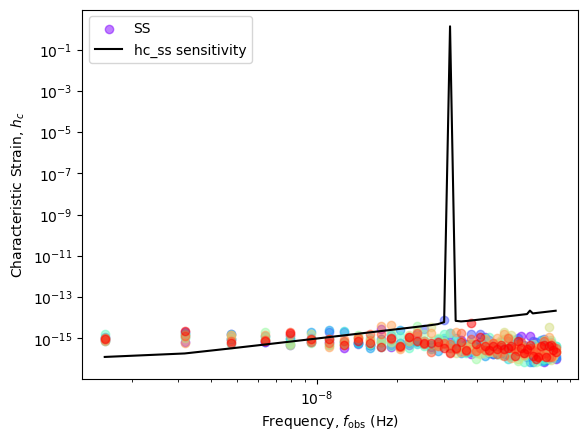

In [147]:
nreals = np.min([10, len(hc_bg[0])])
colors = cm.rainbow(np.linspace(0,1,nreals))
plt.xlabel('Frequency, $f_\mathrm{obs}$ (Hz)')
plt.ylabel('Characteristic Strain, $h_c$')
for rr in range(nreals):
    if(rr==0):
        label_ss = 'SS'
    else:
        label_ss = None
    plt.scatter(fobs, hc_ss[:,rr,ll], alpha=0.5, label=label_ss,
                color=colors[rr])
# plt.loglog(fobs, np.median(hc_bg, axis=1), color='gray', label='median GWB')

plt.loglog(fobs, hc_ss_sens, color='k', label='hc_ss sensitivity')
plt.legend()


It does look like here, every realization has at least one single source above the sensitivity curve at the lowest frequency.